In [2]:
from glob import glob
import os
from itertools import combinations

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [4]:
sigles = 'A','Ant','B', 'BR', 'C','D', 'D2','E', 'F', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'

In [39]:
from lxml import etree
from re import sub #re — Regular expression operations #
import xml.etree.ElementTree as ET
import string


NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'}
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan')

def extract_lines(xml_file, expan = True, punct = True): #added a 'flag' to the extraction function --> if... else
    lines = {}
    tree = etree.parse(xml_file)
    if expan:
        #delete all elements with the provided tag names from a tree or subtree
        #will also remove the tail text unless explicitly set the with_tail keyword argument option to False
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False) 
            
            
    chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
             'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 
             'u', 'v', 'w', 'x', 'y', 'z'}
            
    context = etree.iterwalk(tree, events=("start", "end")) #a tree walker generates events from an existing tree. 'Start' and 'end' represent opening and closing elements
    #u prefix indicates Unicode
    text = u"" 
    #this will be the key in the dictionary of lines {}
    k = '' 
    for action, node in context:
        #remove ns for easier access
        #tag_only bevat de tags op een knooppunt
        #.tag selects all child elements with the given tag. A tag is a string identifying what kind of data this element represents (the element type, in other words).
        #.replace removes ns www.tei...
        
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 

        #node.attrib: XML elements have attributes 
        #attrib is a dictionary containing the element’s attributes. 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] #for example Eerste Martijn
        
        if 'n' in node.attrib and tag_only == "l":
            k = title + '-' + node.attrib['n'] #for example 001, 002, 003...
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        # list elements which you want to iterate through. this is not really neccessary.
        elif tag_only in ("group","text","MVN","body","cb","p"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 

        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
            
            #if a special glyph is present, encode it accordingly
            if tag_only == 'g':

                if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                    text += u'\u0304'

                elif node.attrib['ref'] == '#apomod': # ʼ
                    text += u'\u02bc'

                elif node.attrib['ref'] == '#usmod': # ꝰ
                    text += u'\ua770'

                elif node.attrib['ref'] == '#condes': # ꝯ
                    text += u'\ua76f'

                elif node.attrib['ref'] == '#para': # ¶
                    text += u'\xb6'

                elif node.attrib['ref'] == '#etfin': # ꝫ
                    text += u'\ua76b'

                elif node.attrib['ref'] == '#pbardes': # ꝑ
                    text += u'\ua751'

                elif node.attrib['ref'] == '#pbardes': # ꝕ
                    text += u'\ua755'

                elif node.attrib['ref'] == '#pflour': # ꝓ
                    text += u'\ua753'

                else:
                    node.attrib['ref']
                    text += str(node.attrib['ref']) # get the actual ref if there still are any left

            #encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            #encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            #encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            #if there is still a node with text in it
            elif (node.text):
                text += node.text        

        #after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
        if tag_only == 'lb':
            if punct:
                if k:
                    text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                    lines[k] = text #the value of the keys k is the text 
                    text = '' 
            else: 
                if k:     
                    text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                    lines[k] = text.translate(str.maketrans('', '', string.punctuation)) #the value of the keys k is the text 
                    text = '' 
    #print(lines) 
    return lines

# nog lowercasen (flag) en interpunctie weghalen
d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml', expan = True, punct = False)

In [43]:
mss = {}

for sigle in tqdm(sigles):
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = True, punct = False)
print(mss)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.67it/s]

{'A': {'Eerste Martijn-001': 'VVaphene martin hoe salt gaen', 'Eerste Martijn-002': 'Sal die weerelt hiet langhe staen', 'Eerste Martijn-003': 'In dus crancken loue', 'Eerste Martijn-004': 'So moet vrouwe vereere saen', 'Eerste Martijn-005': 'Sonder twifel ende waen', 'Eerste Martijn-006': 'Rumen heeren houe', 'Eerste Martijn-007': 'Ic zie den valschen wel ontfaen', 'Eerste Martijn-008': 'Die de heeren conen dwaen', 'Eerste Martijn-009': 'Ende plucken vanden stoue', 'Eerste Martijn-010': 'Ende ic zie den rechten slaen', 'Eerste Martijn-011': 'Beede bespotten ende beuaen', 'Eerste Martijn-012': 'Alse die meese in de cloue', 'Eerste Martijn-013': 'Rechts offene god verscroue', 'Eerste Martijn-014': 'Hoe langhe sal ghedoghen dit', 'Eerste Martijn-015': 'God die alle dinc besit', 'Eerste Martijn-016': 'In sine heerscapie', 'Eerste Martijn-017': 'Dat die goede vleeuwet ende bit', 'Eerste Martijn-018': 'Ende hem ne doech no dat no dit', 'Eerste Martijn-019': 'Dat hi hiet ghedie', 'Eerste Mar

In [11]:
print(mss.keys())

dict_keys(['A', 'Ant', 'B', 'BR', 'C', 'D', 'D2', 'E', 'F', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'])


In [12]:
import numpy as np

# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [ ]:
distances = []

for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
    common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
    for idx in common_idxs:
        line1, line2 = mss[ms1][idx], mss[ms2][idx]
        print('=================')
        rx, ry = nw(line1, line2)
        assert len(rx) == len(ry) 
        print('\n'.join([rx, ry]))
        length = len(rx)
        for idx, (a, b) in enumerate(zip(rx, ry)):
            if a != b:
                distances.append((ms1, ms2, idx/length, 1))
            else:
                distances.append((ms1, ms2, idx/length, 0))

  0%|                                                                                                                                                               | 0/120 [00:00<?, ?it/s]

Ende claren vanden sonden
Ende clar--------------e-
Ende wille dat het blike
------------------------
Van gherechtre minnen
Van gh--e---r--------
Pays ende vrede bleue fijn
--------------------------
Ende ander loy bescriuen
------------------------
Wach datti nature oit vant
--------------ere di- vant
Mi dinct dat hu sin ghebrac
----in----------s-- g-ebrac
Borghe ende hoghe steene
------------------------
Dor di doghic meneghen pant
--------------meneg-en pant
Sal die weerelt hiet langhe staen
---------------------------------
Goets es ghenouch lietment gaen
-------------------------------
Ouer zee noch vpten rijn
------------------------
So moet vrouwe vereere saen
---------------------------
Vrecheit leert die weerelt vlaen
Vrech------e----i--------t -l---
Sone bonde mi gheen bant
-----------------en bant
Vvapene vriendelijc viant
--------------elijc viant
Entie redene bevinde
--------------------
Dit euel te beghinne
Dit euel t----------
Ma-c- mi dies in inne
Maect m-------i- ----


  1%|█▎                                                                                                                                                     | 1/120 [00:01<02:46,  1.40s/it]

Niet ghetoghen ha-er- sc-on-e-- lecht
Niet ---toghen hairre scoonheit -echt
Ende cla-r-en vanden sonden
Ende claerse- vanden zonden
Vpwaert ter hemelscher poort
Vpwairt ter hemelscher poirt
Twi torment-- hine met slaghen
Twi tormenten hine met slaghen
Dattu helts ant le-gher bo-rt
Dattu helts an- leggher boirt
Hier -in dine herte dwinc
Hier toe dine harte dwinc
Wie was die eerst---- minne vant
Wie was die eerst die minne vant
H--ets al- een van desen
Hi e-s als een van desen
Dat ic bat--e noch -nie vernam
Dat--s dat ic noyt bate vernam
Van dies ic niet en wiste
Van d-at ic niet en wiste
Ic volghes mi-nen eersten w-orde
Jc volghe- minne- eersten woorde
Die hier ten sonden spoeden
Die hier ten sonden spoeden
Dat soes---e- wille scouwen
Dat soese yet wille scouwen
Houtti dat men di niet en matte
-------Dat-men di niet--- matte
Ende volghen har----e -al ware so ghevloen
Ende volghen hare die hem ware -o--ntfloen
Al tvolc dat woent sonder ghetal
Al tvolc dat woent sonder g-etal
Hi es buten 

  2%|██▌                                                                                                                                                    | 2/120 [00:32<37:22, 19.00s/it]

Dat in dietsch- luudt minne
Dat in dietsche luu-t minne
Daer ic bi scuwen mach die helle
Dair ic bi scuwen mach die helle
Ende claren vanden sonden
Ende claren vanden sonden
Legghen wi thooft hem -inden scoot
Legg-en -- -hooft -in sin-en scoot
Nu willic martin vraghen
Nv willic merten vrag-en
Ende wille dat het blike
Ende wille da----t blike
Van gherecht-re minnen
Van gherechter- minnen
Wie was die eerst minne vant
Wie was die ierst minne vant
Ende ander loy bescriuen
Ende ander loy bescriuen
Wa--ch datti natu-re oit vant
Wapine da-t- natuere di- vant
Men seghet wille-come ghi
Men se--it wille come g-i
Dat d-ede der houerden pont
Dat doe-t der houerd-- -ant
Ic volghes minen eersten w-orde
Jc volch-s minen iersten woorde
Maer -da----t dorp--lijc venijn
Maer tfalsche dorperlijc venijn
Die ons daer bi leert sonder vlien
Die ons daer bi leert sonden vlien
Doe- Noe sijn vader was gram
Dies noe sijn vader was gram
Do-r di doghic meneghen pant
Doer di dog-ic menig-en pant
Ende volghen hare -a

  2%|███▊                                                                                                                                                   | 3/120 [00:42<28:48, 14.77s/it]

Du best die mijns niet -ne vermijt
Du best die mijns niet en- vermijt
Alst do-r doghen siet desen of dien
Alst doer dog-en siet desen of dien
Maer sech mi an welken cant
Maer sech mi an welken cant
Mine minne es der zielen vaer
Mine minne es---- sielen vaer
Die- onghetellede- gods scat
D-en onghete-l-den gods scat
Ende -beghint noch heden
Ende doe----t noch heden
Dijn proeuen w-ert hier jeghen smal
Dijn proeuen waer- hier ieg-en smal
Al sout al varen -inder vaert
Al sout al varen ginder-waert
Alre hande edele fruut
Alre-hande edel- fruut
Van ghiericheden dit martijn
Van ghiericheden---- mertijn
Therte den oghen verwijt
Therte den og-en verwijt
Die mi therte do-r bo-rde
Die mi therte doer boerde
Verdranc die louie felle
Verdranc die luuie felle
--Lettre wort af no an
Woort letter- af no an
Al vindmen dat-tie goede ram
Al vintmen dat die goede ram
Niet ghetoghen haer scone-- lecht
niet gheto-nen haer sconeit -echt
Vpwaert ter hemelscher poort
opwaert ter hemelscher poert
Ende claren van-

  3%|█████                                                                                                                                                  | 4/120 [01:07<36:01, 18.63s/it]


Rijcheit die coninc heue-t of graue
rijcheit die coninc he-eft of graue
-----Die doot ende ander leit
ende die doet ende ander leit
Ende des meinschen houde
ende des me-nschen houde
Ende- niet die ziele scenden
--mer niet die ziele scenden
Pleghen omme te gane
pleghen o-m- te-gane
Man te verheffene bouen man
man te-uerheffen- bouen man
Du best die mijns niet -ne vermijt
du bist die mijns niet en- vermijt
Alst do-r doghen siet desen of dien
alst doer -oghen ziet d-ien of dien
Magherlike drinc ende et
magherlike drinc ende et
So was ontsteruelijc sijn eere
zo was on-steruelijc zijn -ere
Soe was die rouede ende stal
-zi -is die rouede ende stal
Daer ic bi scuwen mach die helle
daer ic bi scuwen mach die helle
Niet ghetoghen haer sco-n-e-- lecht
Niet ghetoghen haer scoenheit -echt
Ende claren vanden sonden
Ende claren vanden sonden
Vpwaert- ter hemelscher poort
Opwaerts ter hemelscher poort
Twi torment hi-ne- met slaghen
Twi torment hi hem met slaghen
Dattu h-elts a-nt legher bo-rt
Dattu 

  4%|██████▎                                                                                                                                                | 5/120 [01:38<44:43, 23.33s/it]


Die mi therte do-r bo-rde
Die my therte doer-boerde
Soe was die rouede ende stal-
S-i -is die roofde ende stal/
Dat in dietsch- luudt minne-
Dat in duytsche l-uyt minne/
Daer ic- bi scuwen mach die helle
Daer ick by scuwen mach die helle
Legghen wi thooft hem -inden sc-oot
Legghen wi thooft -in sin-en schoot
Mesdaden die den wi-sen -messchien
Mesdaden die den wijsen ghe-schien
Nochtan weetic wel sonder waen
----tan weetic---- sonder waen
Dese twee sijn in een be-want
Dese twee sijn in een verbant
Die-s ghelijc-s willic ghereet
Diens ghelijcke wil ic ghereet
Ende gheue-t ons themelsche broot
--Hi ghe-eft ons themelsche broot
Wie was- die -eerst- minne vant
Wie wast die dierste minne vant
Daer ha-re die weerelt mede meit
Daer haer- die w-erelt mede m---
Dit deet mi verleeden
-------- mi verleeden
Ne laet hi ons daer inne
En laet hi ons daer inne
Dat ic bate noch nie vernam
--t--- bate ----en-- vernam
Nu spr-ec-- ic saelt ontbenden
Nv -vraecht ic sa-l- ontbenden
Steden bo-sch b-erch ende

  5%|███████▌                                                                                                                                               | 6/120 [01:45<33:46, 17.78s/it]


Al sout al varen --inder vaert
------t al varen ghinder-waert
No-- gherust- no-- ghetes
Noch gheruste noch ghetes
Also helpe mi sente baue
-----------mi s---e baue
Dat hi si-t inder hel--len brant
Dat hi sidt inden helschen brant
Nu es mijn herte so- hart .I. vlint
---es mijn herte soe ver------blint
Die mi therte do-r b-orde
Die mi therte doer-boorde
Dat soe- ha-r--e -jet daer toe verbint
--- -hem daertoe niet --e----n verbint
Al dat oint maect---e si-ne hant
Al da-----t maecte ye sijn- hant
Hi stor-te do-r ons sijn bloet root
Hi stortte voer ons sijn bloet root
Al had-dic a-ne .II. yserine sc-oen
Al hadt ic aen- twee yseren- scho--
Ic vergheue- al onghedout
Ic vergheuet al onghedo--
-Entie reden--e tontmoetene pliet
Die de reden te -ghemoeten- pliet
Legghen wi thooft hem -inden scoot
Legghen wi thoo-t -in sin-en scoot
Nu willic martin vraghen
Nv willic merten vraghen
Vpten ho-ghesten ban
Opten hoech-sten ban
Ende gheue-t ons themelsche broot
Ende g-e-eft ons themelsc-e broot
Maer go

  6%|████████▊                                                                                                                                              | 7/120 [01:50<25:34, 13.58s/it]


Cracht die twee her----t---en bint
Cracht die -II. herten tsamen bint
Verdranc--- die --louie felle
Verdranc in die delouie felle
Nu hort die leeren can
Nv lere die l-eren can
Ende vercopen omme ghelt
Ende vercopen omme ghelt
Hi storte do-r ons sijn bloet root
Hi storte doer ons sijn bloet root
Dese scuwen der eeren pat
Dese scuwen der -eren pat
Onghewonnen ende ongheboren
Ong-ewonnen ende ong-eboren
-----Lett-re wort af no-- an
Wort lettere----n af noch an
Hets daer ic mi omme liet ontliuen
Hets daer ic my o-m- liet on-liuen
Dat oint ter eeren trecte
Die o-yt ter -eren trecte
Al vindmen dat-tie goede ram
Al vintmen dat die goede ram
Bescrijft ons die bibe-l----e fijn
------Dat -al dat -gheslechte sijn
Niet ghetoghen haer scone lecht
Niet gheto-nen haer scone lecht
Ende claren vanden sonden
Ende claren vanden sonden
Vpwaert ter hemelscher poort
Opwaert ter hemelscher poort
Twi- torment hine met slaghen
Twij torment hine met slag-en
Dattu helts ant -legher b-ort
Dattu hel-s ant dlegher

  7%|██████████                                                                                                                                             | 8/120 [02:20<34:51, 18.67s/it]


So was ontsteruelijc sijn eere
So was on-sterfeli-c ziin eere
Al sout al varen --inder vaert
Al sout al varen ghinder waert
Die mi therte do-r b-orde
Die mi therte doir boorde
Soe was die rouede ende stal
Sij -es die rouede ende stal
Dat in dietsch- luudt minne
Dat in duutsche luu-t minne
Daer ic bi- scuwen mach die helle
Daer ic bij scuwen mach die helle
Vvat mochte verhieue dat ad-m
---t mocht- -----eua dat adam
Ende men co-pet o-ndiere
-nde men coep-t om diere
Het wert ten joncsten daghe claer
Het wort ten --lesten------ -maer
Waren die manne- also behoet
-aren---- mannen --so behoet
Daer men leuet sonder vaer
Daer-men leuet sonder vaer
Toter hogher heruen
--ter hog-er -eruen
Die zielen int -helsche dal
Die siel-- int thel--le dal
Sulc thyent den vrouwen vpsien
SElc t-ient den vrouwen ------
Omme die vrouwe hoghe
O-m- .j. vrouwe hog-e
Ghedanct si soes menichfout
G-edanct si-s-e- menichfout
Dat si hem dat herte ontien
Dat si hem --t-herte onti--
So nauwe om hare scoenheit spien
So n

  8%|███████████▎                                                                                                                                           | 9/120 [02:22<24:56, 13.48s/it]

Dat soe adame therte stal
Dat s-i adame therte sta-
Daer ons af quam onse behout
Daer---- af quam ons- behout
Bi e--ere maniere-
-- ender- manieren
--Waert al dijn dat comt int -swin
Alwaert--- dijn dat comt int tswin
Dan te wandelen daer om trent
--n te wandelen daer om-trent
Da-t- h-i e--ene weruen
Datti hem eruen- weruen
Ende dat oint was sonder ghetal
Ende---- -i-e was sonder g-etal
Senden ten helschen viere
---den ten helsc-en viere
Maer die wech es nauwe ende zwaer
-----Die wech es hoech ende swaer
Ic vergheue al onghedout
Ic verg-eue al ong-edout
Eer hem therte --daelde
-er hem therte ontaelde
Dat soene vp hi-lt met soghe
Dat s-ine op hielt met sog-e
Sine- minnen niet v-or-den scat
si en minnen niet voor den scat
Ende aermoede ane-vaen
ende a-rmoede ane vaen
--Noch-- niet te messchiene
ende hem niet te messc-iene
Haer hant es altoes sonder gat
haer hant is altoos sonder gat
So dolen dese vroede
so dolen dese vroede
Vvaenstu ma-rtin weeldich vet
-Waenstu maertin weeldich vet
Eist

  8%|████████████▌                                                                                                                                         | 10/120 [02:23<17:39,  9.63s/it]


Dat si wi---sen doe al dat
dat si di raden doe al dat
---Wel hem diere hem an keerde
so wel hem diere hem an keerde
Eist dattu w-ilt sijn sijn let
eist dattu wesen wilt gods let
Omme die helle tontvliene
-om- d-e helle tontvliene
Doch--- vint mer sonder waen
nochtan vint-mer sonder waen
Aermoede prijstmen menich fout
aermoede pri-s--ic menich-fout
Dat meer goeds begh-erde
dat meer scats begheerde
Eist leec clerc ionc of hout
eest leec clerc ionc of -out
Niet ghetoghen haer scone lecht
-------------------------------
Ende gheuen der eeren eenen ban
Ende gheuen der -eren -enen ---
Dattu helts a-nt legher b-ort
Dattu hel-s aent legher boort
Waren die manne also- behoet
Waren---- manne alsoe behoet
Dat ic------ bate noch nie verna-m
Dat ic noeyt bate ----en-- vernaem
Steden bosch- b-erch ende preit
Steden borghe bossch----e preit
Dat aermoede es een pat
-------moede es een pat
Di---e- hier ten sonden spoeden
Die hem hier ten sonden spoeden
Van si-re onsa-licheit
Dan siere onsaelicheit
Die

  9%|█████████████▋                                                                                                                                        | 11/120 [02:31<16:45,  9.23s/it]


Daer ic bi scuwen mach die helle
Daer ic bi scuwen mach die helle
Niet ghetoghen haer scone lecht
Niet ghetoghen haer scone lecht
Ende claren vanden sonden
Ende claren va---n sonden
Vpwaert ter hemelscher poort
Vpwaert ter hemelscher poort
Twi- torment hi-ne met slaghen
Twij torment hijne met slaghen
Dat-tu helts an-t legher b-ort
Datstu helts an t-legher boort
Hier -in di-ne herte dwi-nc
Hier toe dijne herte dwijnc
Wie wa-s- die eerst minne vant
Wie waest die eerst minne vant
Het--s al een van d-esen
Het es al een van deesen
Dat ic----- bate noch nie vernam
Dat ic noyt bate ----en-- vernam
Van dies ic niet en wiste
Van d-at ic niet en wiste
Ic volghes minen eersten w-orde
Jc volg--s minen eersten woorde
Die hier ten sonden spoeden
Die hier tot zonden spoeden
Dat soese wille scouwen
Dat hae-r wille scauwen
Houtti dat men di niet en matte
-------Dat men di niet en matte
Ende volghen ha-r---e -al wa-re so ghevloen
Ende volghen haer die hem waere--- gheuloen
Al tvolc dat woent sonder ghe

 10%|███████████████                                                                                                                                       | 12/120 [03:01<27:47, 15.44s/it]


Al sout al varen -inder vaert
Al sout al varen hinder-uaert
Die mi therte do-r b-orde
Die my therte doer-boorde
Soe was die rouede ende stal
Zij was die roofde ende stal
Dat in dietsch- luudt minne
Dat in duutsche luu-t minne
Daer ic bi scuwen mach die helle
Daer ic by scuwen mach die helle
Vp-waert ter hemelscher poort
Op w-ert ter hemelscher poert
Hier in di-ne herte dwinc
Hier in dijn- herte dwinc
Sine ghewerken daer me-n- kent jnne
Sine g-ewerke- daer menne kint jnne
Van si-re onsalicheit
Van siere onsalecheit
So was hi vele minder----- zeere
So was hi----- minder vele seere
Hoe mijn ghelo-ue sonder ho-ne
Hoe mijn g-eloeue sonder hoene
Ende eeuwelike sijn ghevr-------------------------------eest
Ende -e-weleke sijn g-evreest : 130 Jn den helschen tempeest
Even gheweldich ende heere
Euen g-eweldech ende h-ere
Hi es buten a-l------ nv merke
Hi es buten alle dinc nu herke
----In dese- -----weerelt cr-anc
MErten nu en clach no e-n croene
Dat ha--re eenich te vullen toghe
Dat haerre ee

 11%|████████████████▎                                                                                                                                     | 13/120 [03:09<23:45, 13.32s/it]


Leerde ende maecte in jnne
Leerde ende maecte in inne
So was ontsteruelijc sijn------------------ -e---e--re--
So was on-ster-fl-ec sijn ere : 321 Dit was een bescheit
Die alle dinghen mach versaden
Die alle din---c mach versaden
-Le-ttre wort af no---- an
Woert lettere af -ochte an
Daer ic bi scuwen mach die helle
Daer ic bi scumen mach die helle
Niet ghetoghen haer sco-n-e-- lecht
Niet g-etoghen haer scoenheit -echt
Ende gheuen der eeren eenen ban
Ende gheuen der eeren -enen ban
Dattu helts a-nt -legher b-ort
Dattu hel-s aen- dleg-er boort
Van si--re onsalicheit
----sijnre onsalicheit
Die -in twifele wa-re beuaen
Die met twiuel- waer- beuaen
Die de heeren co-nen dwaen
Die de heeren connen dwaen
Wapene god die dit verheeste
----ne god die dat verheeste
Hoe mijn -gheloue sonder hone
Hoe m-en tg-eloue s-------on-
Sal die weerelt hiet langhe staen
----hoe --saelt gae----n- 2 -Sa-l
God siet alle dinc ende ho-rt
God siet alle dinc ende hoert
Dat nemmermeer vergheet
--- -e-welike- ---steet

 12%|█████████████████▌                                                                                                                                    | 14/120 [03:15<19:30, 11.04s/it]


Aflaet groot van haren sonden
Aflae------t van haren zo---n
Recht man deluet sonder spit
Recht man deluet sonder spit
Alse die meese in d-e cloue
Alse die meese in die cloue
Nu noch te gheenen stonden
Nv noch te gh-enen stonden
Leerde ende maecte -in jnne
-----e ende maecte .I. inne
Daer ic bi scuwen mach die helle
Daer ic bi scuwen mach die helle
Ende claren vanden sonden
Ende claren vanden sonden
Legghen wi thooft hem inden scoot
Legg-en wi th-o---uet inden scoet
Nu willic martin v---raghen
Ic wi-l-t merten verdrag-en
Van gherecht-re minnen
Van g-erechter- minnen
Hier in di-ne herte dwinc
Hiertoe dijn- herte dwinc
Wa-ch datti natu-re oit vant
Wapen da-t- natuere di- vant
Men seghet willecome ghi
Men se--it willecome ghi
Maer dat dorp--lijc venijn
Maer dat dorperlijc venijn
Tsamen -in een reene- wanen
----In een--en reynen wane-
Si-ne ghewerken daer men kent jnne
Sijn- ---werken daer-men kint inne
Doe Noe sijn vader was gram
die noe sijn vader was gram
Houtti dat men di niet en matte

 12%|██████████████████▊                                                                                                                                   | 15/120 [03:25<18:56, 10.82s/it]


Verdranc die --louie felle
Verdranc die deluuie felle
-Lettre wort af no an
Wort lettere af no an
Al vindmen dattie goede ram
Al v---alt dattie goede ram
Ende cla-r--------------e-
Ende claerse vanden zonden
-----------------------
Ende wille dattet blike
Van g-----h-er------
Met gherechter minne
--------------------------
Pays ende vrede bleue fijn
------------------------
Ende ander loy bescriuen
-----e---------re di- vant
Wapene dat nature dit vant
----in----------s-- g-ebrac
Mi dincke dat v sin ghebrac
------------------
Borghen ende stene
-----------------meneg-en -pant
Doir di doghe ic menighen brant
----------------------------
Sal de werelt yet lang staen
------------------------------
Goets es genoich lietment gaen
------------------------
Ouer zee ende opden rijn
----------------------------
So moet mijn vrauwe ere zaen
Vrech------e----i-------t -l---
Vrecheit leert die werelt vlaen
------------------en bant
So en bonde mi gheen bant
------------elijc viant
Wapen vriendeli-c

 13%|████████████████████                                                                                                                                  | 16/120 [03:26<13:26,  7.76s/it]

-En- -----e-s niet------
Hens wijsheit niet dinne
---------------n .I. sant
Lichter ware dan een zant
M-------------ij----n he--rt
Mine redene blijft onghesont
-----------------
Ende menich coude
Ic liet m---------------------
Ic liet mi costen wel een pont
---------------------
Der menscheit ghemene
---------------------------------
Der herten ende der oghen vertuut
-----------------ijt
In dus crancken loue
--------------------------------
Ende dair toe een ewelic verwijt
------------------ houde
Ende des smenschen houde
--------------------
Alst doet jammerlike
--------------------------
Dattet wair is sonder waen
-----------------------------------
Hier omme so stichtmen metter spoet
-----------------------
Die airme worden vonden
--------------t---s----- g-elo--g-en-
Ende vrient dit nes niet ghelo#«ghen»
---------------------------------
Du beste die minnens niet vermijt
So---------e viel---- ----
So vele alle oirloghe zaen
----------------------n
Des claghe ic den oghen
Alrehan---

 14%|█████████████████████▎                                                                                                                                | 17/120 [03:26<09:37,  5.61s/it]


---------------------vo-r lijt
Daer soe menich dief voer lijt
----------------------------
Jnt ghemene ende hem ontfaen
--------------uw-ert lac
Want mi noit tuwaert lac
---------------woude
Op dat natuere woude
-------En ---e-s --niet
Na dat ic redene kinne-
----------------n .I. sant
Lichter waric dan .j. sant
M------------------ijn hert
Mine besceede dit dijn mont
-----------------
Ende menich coude
Ic liet m-----------------
Jc liet mi costen .j. pont
---------------------
Der menscheit gemeene
----------------------------
Dan die hem deuel toe seinde
------------------------------
Ende daer toe een ewelijc nijt
----------------- houde
Ende des menschen houde
--------------------
Alst doot jammerlike
---------------------------
Dat dit waer es sonder waen
------------------------------
Hier om stichtmen metter spoet
----------------------
Die arme worden vonden
-----------------ts gelogen
Du best vrient dats gelogen
---------------------------------
Du best die mijns niet en vermi

 15%|██████████████████████▌                                                                                                                               | 18/120 [03:27<06:58,  4.10s/it]

------------------uwert lac
want noyt van mi tuwart lac
-----------------woude
waert dat nature woude
--En -----e-s niet-------
hets wijsheit niet dinnen
---------------n .I. sant
lichter ware dan een zant
Mij------n-------- ---he--rt
mijn redene blijft onghesont
-----------------
ende menich coude
Ic lie-------t---------- ---m
ic lietmi costen wel een pont
---------------------
der menscheit ghemene
---------------------------
dan die hem teuel toeseinde
i----------------jt
in dus cranken loue
----------------------------
ende daertoe een ewelic nijt
----------------- houde
ende des menschen houde
-----------------------
als het doet jamerlike.
-------------------------
dat alwaer is zonder waen
------------------------------
hier om stichtmen metter spoet
-----------------------
die aerme worden vonden
-----------------ts g-elog-en
du bist vrient dits gheloghen
---------------------------------
du bist die mijns niet en vermijt
Soe vi-------e-l----- ----
dus viel al oerloeghe zaen
--

 16%|███████████████████████▊                                                                                                                              | 19/120 [03:28<05:07,  3.04s/it]

---------------------vo-r lijt-
Daer soe menich dief voer lijt/
------------------------------
Int ghemeyne ende hem ontfaen/
------------------uwert lac-
Want noyt van mi tuwert lack
---------------woude
Op dat natuere woude
En----- -es ni---e-t------
Ende is met wijsheyt dinne
-------------------n .I. sant-
Lichter waer ick dan een zant:
Mij------n------- ---he--rt
Mijn reden bliuet onghesont
-------------------
Ende menighe coude.
Ic li--et m---------------------
Ic lietet my costen wel een pont
----------------------
Der menscheyt ghemeyne
---------------------------------
Der herten ende der hoger virtuyt
----------------------ijt
In desen crancken gheloue
--------------------------------
Ende daer toe een eewelijck nijt
----------------- houde
Ende des menschen houde
---------------------
Alst doet iammerlijke
--------------------------
Dattet waer is sonder waen
--------------------------------
Hier om stortmen smenschen bloet
-------------------------
Die arme worden gheuonden


 18%|███████████████████████████▍                                                                                                                          | 22/120 [03:28<02:21,  1.45s/it]

---------------moude
Onder donreyne moude
---------------emt mi inne
Een stof al quaemt mi inne
--------
Sal dese
-------
WAphene
------------------------------
Soe sal mijn vrouwe veren saen
------------------ijt
In dus crancken loeue
Ende clar-----------e-
Ende claren van sonden
------------------------
Ende wille dat het blike
--Van-- gher------
Met noyaeler minne
--------------------------
Pays ende vrede bleue fijn
-------------------------
Ende ander loy bescriuen.
----ere---- di-------- vant
Waphene dat die nature vant
------------------ins g-ebrac
My dijnct dat di zins ghebrac
-------------------------
Burghen ende hoghe steene
----------------meneg-en -pant
Dor di doghe ic menighen brant
-------------------
hoe salt gaen 2 Sal
-------------------------------
Goets es ghenouch lietment gaen
-----------------------------
Ouer die zee noch vp den rijn
----------------
So zal mijn vrau
Vrechei-----------------t -l---
Vrecheit leert de weerelt vlaen
---------------------en bant
So 

 22%|████████████████████████████████▌                                                                                                                     | 26/120 [03:29<01:12,  1.29it/s]


---------------emt mi inne
Een stof al quaemt my jnne
--------------------
hoe saelt gaen 2 Sal
---------------
WAphene martijn
---------------------
staen. 3 In dus cranc
---------ijt-------
dese weerelt langhe
Ende clar--------------e-
Ende claren vanden sonden
Van g----h-er-------
Van gerechter minnen
--------------ere di vant
Wapen dat natuere di vant
-----------ins gebrac
Ic waen v sins gebrac
----------------------
Borge ende hoge steene
------------menegen pant
Dor u dogic menegen pant
------------------------------
Goets es genoech lietment gaen
Vrech------e----i----t -l---
Vrecheit leert die wlt vlaen
----------------en bant
Sone bonde mi geen bant
------------elijc viant
Wapen vriendelijc viant
--------------------
Ende te redene vinde
Dit euel t-----------
Dit euel ten beghinne
Maect mi-------- ----
Maect mi des een inne
Ende ic------s------ ---vr------
Ende icts wijs werde deser stont
----------------------
Dat elc set sinen moet
Dat noit do-------------
Dat noit dorper en

 24%|████████████████████████████████████▎                                                                                                                 | 29/120 [03:29<00:51,  1.78it/s]

---------------------vor- lijt
Daer soe menich dief uore lijt
---------------------------
Int gemeen ende hem ontfaen
--------------uw-ert lac
Want mi noit tuwaert lac
---------------woude
Op dat natuere woude
-----En es n-----i---e-t------
Want en es niet wijsheit dinne
-----------------n .I. sant
Lichter waeric dan een sant
Mijn her-----------------t
Mijn herte bliuet ongesont
------------------
Ende meneghe coude
Ic liet m---------------------
Ic liet mi costen wel een pont
----------------------
Der menscheit ghemeene
-----------------------
Dan hem deuel toe sinde
-----------------------------
ende daertoe een ewelijc nijt
----------------- houde
Ende des menschen houde
---------------------------
Dat dit waer es sonder waen
------------------------------
Hier om stichtmen metter spoet
----------------------
Die arme werden vonden
--ts ge--------logen
Bedi benic dorulogen
------------------------------
Dv best die mijns niet vermijt
Soe vi--e------l--- ----
Dus viele al orloge zae

 25%|█████████████████████████████████████▌                                                                                                                | 30/120 [03:43<03:45,  2.51s/it]


Niet ---toghen hairre scoonheit echt
niet gheto-nen ha-er- sc-on-eit echt
Vpwairt ter hemelscher poirt
opwaert ter hemelscher poert
Ende claerse- van-den zonden
ende cla-r-en van den zonden
Twi tormenten hine met slaghen
twi torment-- hine met plaghen
Dattu hel-ts a-n- l-eggher boirt
dattu heldes aent lae-gher boert
Hier toe di-ne harte dwinc
hier-toe dijn- herte dwinc
Hi es als e-en van desen
hi is al-lene- van desen
Die minst wa--s ende wort meest-
die minst waert ende w-as meest.
Van dat ic niet en wiste
van dat ic niet en wiste
Ende heue-t t--onser --vromen
ende he-eft te onzer onvromen
Die hier ten sonden spoeden-
die hier ten zonden spoeden.
Datmen di nie-t matte
datmen di niene matte
----Hi- es buten al nv mercke
noch is hi buten al nu her-ke
Die besittere es emmermere
die besitter- is emmermere
Van gode ghedanct die noyt ende -al
van gode ghedanct die n---ien-e hal
Ken-t hi vro-me of scade
kende hi vroem- of scade
----Smaict allene de- vr-emden mont
het smaect allene der vrien

 26%|██████████████████████████████████████▊                                                                                                               | 31/120 [04:18<11:53,  8.01s/it]


Magherlike drinc ende et
magherlike drinc ende et
---Was ontster-flijc onse here
zo was on-steruelijc zijn -ere
So es die rouede ende stal
zi is die rouede ende stal
Dair ic bi scuwen mach die helle
daer ic bi scuwen mach die helle
Niet ---toghen hairre scoonheit echt
Niet ghetoghen ha-er- scoenheit echt
Ende claerse- vanden zonden
Ende cla-r-en vanden sonden
Vpwairt- ter hemelscher poirt
Opwaerts ter hemelscher poort
Twi tormenten hi-ne- met slaghen
Twi torment-- hi hem met slaghen
Dattu h-elts a-n- leggher boirt
Dattu houdes aent l-agher boert
Hier toe di-ne harte dwinc--
Hier toe dijn- herte dwinck:
Wie was- die eerst die minne vant
Wie wast die eerst---- minne vant
Hi es als een van desen
Hi is al- een van desen
Dats dat ic- noyt ba-t-e- vernam
-----dat ick noyt baet en vernam
Die minst w-as ende wort meest-
Die minst wert ende w-as meest:
Van dat ic- niet en wiste
Van dat ick niet en wiste
Jc- volghe minne eersten woorde
Ick volg-s -den- eersten woerde
Ende heue-t tonser --vromen

 27%|████████████████████████████████████████                                                                                                              | 32/120 [05:03<22:23, 15.26s/it]


So es die rouede ende stal-
Si is die roofde ende stal/
Dat in dietsche luut minne-
Dat in duytsche luyt minne/
Dair ic- bi scuwen mach die helle
Daer ick by scuwen mach die helle
Legghen wi thooft in zinen sc-oot
Legghen wi thooft in sinen schoot
Mesdaden die den wi-sen ghesc-ien
Mesdaden die den wijsen gheschien
Nochtan w-etic sonder waen
----tan weetic sonder waen
Dese tw-e zijn in een be-want
Dese twee sijn in een verbant
D-e-s ghelijc-s wil ic ghereet
Diens ghelijcke wil ic ghereet
Ende gheeft ons dat hemelsche broot
--Hi gheeft ons --t-hemelsche broot
Wie was- die -eerst die minne vant
Wie wast die dierst---e minne vant
Dair hair die werelt mede meit
Daer haer die werelt mede m---
Dat deit mi verl-eden
-------- mi verleeden
Sone laet hi ons dair jnne
-En- laet hi ons daer inne
Dats dat- ic noyt bate vernam
--t- bate --en-------- vernam
Nu vra-ch- ic sal on-benden
Nv vraecht ic sal ontbenden
Steden burghen busschen preit
Steden/borg-en/bossc-en preyt
Dit prouftmen mit zinne
Dit p

 28%|█████████████████████████████████████████▎                                                                                                            | 33/120 [05:06<18:25, 12.71s/it]


Hier toe -n-es gheen verwinnen
--e--toe en is g-een versinnen
Al soudt al varen --inder vaert
-------t al varen ghinder-waert
Noch gheruste noch ghesces
Noch gheruste noch ghe-tes
Also help mi sinte baue
----------mi s---e baue
Dat hi si-t inder hel--len brant
Dat hi sidt inden helschen brant
Nu es mijn harte so- hart j. blint
---es mijn herte soe ver-----blint
Die mi tharte doir boorde
Die mi therte doer-boorde
Dat so hair dair toe -yet--- verbint
------ h-em daer-toe niet en verbint
Al dat oyt maict---e zi-ne hant
Al da----t maecte ye sijn- hant
Hi stor-te doir ons zijn bloet root
Hi stortte voer ons sijn bloet root
Al had-dic a-n tw-e yseren sc-oen
Al hadt ic aen twee yseren scho--
Ic vergheue- al ong-edout
Ic vergheuet al onghedo--
--Ende reden--e ghemoeten pliet
Die de reden te ghemoeten pliet
Legghen wi thooft in zinen scoot
Legghen wi thoo-t in sinen scoot
Nu willic martin vraghen
Nv willic merten vraghen
Op den hoichsten ban
Op-ten hoechsten ban
Ende gheeft ons dat hemelsche b

 28%|██████████████████████████████████████████▌                                                                                                           | 34/120 [05:11<15:29, 10.81s/it]

Cracht die twee harten te gader bint
Cracht die -II. herten t--samen bint
Verdranc--- die diluuie felle
Verdranc in die delouie felle
Nu hore die leren can
Nv lere die leren can
Ende vercopen o-m- ghelt
Ende vercopen omme ghelt
Hi storte doir ons zijn bloet root
Hi storte doer ons sijn bloet root
Dese scuwet der heren pat
Dese scuwen der -eren pat
Onghewonnen ende ongheboren
Ong-ewonnen ende ong-eboren
Woort no lettere- of no-- an
W-ort--- letteren af noch an
Hets dair ic mi omme liete ontliuen
Hets daer ic my o-m- liet- on-liuen
Dat oyt ter eren trecte
Die oyt ter eren trecte
Al vintmen dat d-e -ongaue ram
Al vintmen dat die go--ede ram
Scriuet ons die bibe-l----e fijn
----Dat -al dat -gheslechte sijn
Niet ---toghen hairre scoonheit -echt
Niet gheto-nen ha-er- sc-on-e-- lecht
Ende claerse- vanden zonden
Ende cla-r-en vanden sonden
Vpwairt ter hemelscher poirt
Opwaert ter hemelscher poort
Twi- tormenten hine met slaghen
Twij torment-- hine met slag-en
Dattu helts an- -leggher boirt
Dat

 29%|███████████████████████████████████████████▊                                                                                                          | 35/120 [05:50<25:26, 17.96s/it]


Dair ic bi- scuwen mach die helle
Daer ic bij scuwen mach die helle
Wat mochts vrau eua dat adam
--t mocht------ eua dat adam
Ende men coept o-ndiere
-nde men coept om diere
Het wert ten jonxsten daghe clair
Het wort ten --lesten ma--e-----r
Wair een ma---n so behoet
-a-r--en mannen so behoet
Dairmen leuet sonder vaer
Daermen leuet sonder vaer
Ter vpperster erue-
ter ----hoger eruen
Die zielen int -helsche dal
Die siel-- int thel--le dal
SVlc tye-t der vrauwen opzien
SElc tient den vrouwen ------
Doir die vrouwe hoghe
--Om .j. vrouwe hog-e
Gheloeft so sie dusentichuout
G-edanct s-is-e --men-ichfout
Dat si hem dat herte ontyen
Dat si hem --t-herte ont--i
So nauwe om hare scoonheit spien
So nau-- om hare scoenheit s----
Ic waenre- ons voordeel of quam
-- waender ons v-ord-el af quam
Es die wech nauwe ende hooch
Es die wech nau-- ende hoech
In ha-re ben ic te endene bout
In haer- ben-ic t--enden- bout
Die valsche worden vrauwen toezint
--e vals--- wor--t vrouwen ---sint
Martin h--i -es n

 30%|█████████████████████████████████████████████                                                                                                         | 36/120 [05:57<20:52, 14.91s/it]


Ic vergheue al ongedout
Ic verg-eue al ongedout
Eer hem therte --daelde
-er hem therte ontaelde
Dat si hem op h-elt mit zoghe
Dat si-ne- op hielt met sog-e
Si-en minnen niet voir-den scat
si en minnen niet voor den scat
Ende armoede on-tfaen
ende armoede ane vaen
Ende hem niet te messciene
ende hem niet te messciene
Hair hant es altois sonder gat
haer hant is altoos sonder gat
So dolen dese vroede
so dolen dese vroede
Waenstu ma-rtijn weeldich vet
Waenstu maerti-n weeldich vet
-Est als- ic mi be-moede
eist also ic mi vermoede
Sijn ghecleet nv wel nv bet
siin ghecleet nv wel nv bet
Ne volghe niet sulken heerde
---volghe niet sulke- heerde
Hier in --est zekerst volstaen
hier in waert sekerst vulstaen
-Al dinct mi--- wesen gader gout
het dinct mi al wesen gader gout
Die armoede --es een pat
die armoede dats .i. pat
Ende zine recht-re zide ghesplet
ende sine rechter- zide ghesplet
Si heten vasten -ende si sijn sadt
si heten vasten me--r si siin sa-t
Tormentieren ende v-aen
torment-eren en

 31%|██████████████████████████████████████████████▎                                                                                                       | 37/120 [06:02<16:55, 12.24s/it]

-Armoede prisic menichuout
aermoede prisic menichfout
Dat meer tgoet- begheerde
dat meer -scats begheerde
Eist clerc -leec ionc of oudt
eest -leec clerc ionc of ou-t
Niet toghen hairre scoonheit echt
---------------------------------
Ende gheuen der eren enen ban
Ende gheuen der eren enen ---
Dattu helts a-n- leggher boirt
Dattu hel-s aent le-gher boort
Wair een ma-n- --so- behoet
Wa-r--en manne alsoe behoet
Dats dat ic no-yt bat--e- verna-m
D-----at ic noeyt bate en vernaem
Steden burghen busschen preit
Steden borghe- bossche- preit
Die armoede es een pat
------moede es een pat
Di---e- hier ten sonden spoeden
Die hem hier ten sonden spoeden
Van si-re onsa-licheit
Dan siere onsaelicheit
Die mit twiuele ware beuaen
Die met twi--------- beu---
Dat soese -yet--- wille scouwen
Dat -icse niet en wille scouwen
Die de heren connen doerstaen
Die de heren connen d----waen
In ha-re ben ic te endene bout
In haer- ben-ic t--inden- bout
Waphene god die dat b verheeste
Wap-ene god die dat-- ver-eest

 32%|███████████████████████████████████████████████▌                                                                                                      | 38/120 [06:14<16:44, 12.25s/it]


Ic vergheue al ongedout
Ic verg-eue al ongedout
Dair ic bi scuwen mach die helle
Daer ic bi scuwen mach die helle
Niet ---toghen hairre scoonheit -echt
Niet ghetoghen ha-er- sc-on-e-- lecht
Ende claerse- vanden zonden
Ende cla-r-en va---n sonden
Vpwairt ter hemelscher poirt
Vpwaert ter hemelscher poort
Twi- tormenten hi-ne met slaghen
Twij torment-- hijne met slaghen
Dat-tu helts an -leggher boirt
Datstu helts an tle-gher boort
Hier toe di-ne harte dwi-nc
Hier toe dijne herte dwijnc
Wie wa-s- die eerst die minne vant
Wie waest die eerst---- minne vant
H-i es als een van d-esen
Het es al- een van deesen
Dats dat ic noyt bat--e- vernam
D-----at ic noyt bate en vernam
Die minst wa-s ende wort meest
Die minst wart ende w-as meest
Van dat ic niet en wiste
Van dat ic niet en wiste
Jc volghe min-ne eersten woorde
Jc volg-s minen- eersten woorde
Ende heuet tonser vromen
Ende heuet tonser vromen
Die hier ten sonden spoeden
Die hier tot zonden spoeden
Dat soese yet wille scouwen
Dat -----haer w

 32%|████████████████████████████████████████████████▊                                                                                                     | 39/120 [06:48<24:54, 18.45s/it]

-So -es die rouede ende stal
Zij was die roofde ende stal
Dat in dietsche luut minne
Dat in duutsche luut minne
Dair ic bi scuwen mach die helle
Daer ic by scuwen mach die helle
Vp-wairt ter hemelscher poirt
Op w-ert ter hemelscher poert
Hier toe di-ne harte dwinc
Hier -in dijn- herte dwinc
Die minst w--as ende wort meest
Die minst werdt ende w-as meest
An--den vader van hemelrike
Ane den vader van hemelrike
Ende heue-t t----------o-----------ns------er------ v-r-o-men
Ende he-eft tonser onvromen : 278 Onse vorders doen verdoemen
Sine ghewerke dair-me-nt kent jnne
Sine g-ewerke daer menne kint jnne
Van si-re onsalicheit
Van siere onsalecheit
Ende an--den zone dies ghelike
Ende ane den sone dies g-elike
So was hi vele minder----- -zere
So was hi----- minder vele seere
Hoe mijn ghelo-ue sonder ho-ne
Hoe mijn g-eloeue sonder hoene
Ende ewelike zijn ghevr-------------------------------eest
Ende eweleke sijn g-evreest : 130 Jn den helschen tempeest
Euen gheweldich ende here
Euen g-eweldech 

 33%|██████████████████████████████████████████████████                                                                                                    | 40/120 [06:58<21:18, 15.98s/it]


Niet --toghen hairre scoonheit echt
Niet getoghen ha-er- scoenheit echt
Ende gheuen der -eren enen ban
Ende gheuen der eeren enen ban
Dattu helts a-n -leggher boirt
Dattu hel-s aen dle-g-er boort
Van si--re onsalicheit
----sijnre onsalicheit
Die mit twiuele wa-re beuaen
Die met twiuel- waer- beuaen
Die de h-eren connen doerstaen
Die de heeren connen d----waen
Waphene god die dat b verheeste
-----ne god die dat-- verheeste
Hoe mijn -gheloue sonder hone
Hoe m-en tg-eloue s-------on-
Sal de werelt -yet lang staen
---hoe -saelt gaen ---2 -Sa-l
God siet alle dinc ende ho-rt
God siet alle dinc ende hoert
Dat nemmermeer -te gheet
--- -e-welike- st----eet
Dair bi ontsteict dat droghe
Daer bi ontste-ct dat drog-e
Iacop segt bestu verd-ort
Iacob segt bestu verdoort
its des vaders ende des zoens gaue
---------------------------------Ø
Dus es die gods zone als ic scriue
Dus es die gods sone als-ic scriue
-Ende die neuel mi-t- si-re drecht
Son-e --can---- si te diere vre--n
Ende zulc zijns lants v

 34%|███████████████████████████████████████████████████▎                                                                                                  | 41/120 [07:03<17:02, 12.95s/it]


Oflaet groot van haren sonden
Aflae------t van haren zo---n
Recht als een man deluet sonder spit
Recht-------- man deluet sonder spit
Als- die m-eze in d-e cloue
Alse die meese in die cloue
Nu noch te ghenen stonden
Nv noch te ghenen stonden
Leerde ende make-de -in jnne
-----e ende ma-ecte .I. inne
Dair ic bi scuwen mach die helle
Daer ic bi scuwen mach die helle
Ende claerse- vanden zonden
Ende cla-r-en vanden sonden
Legghen wi thooft in zinen scoot
Legg-en wi thouet in---den scoet
Nu willic martin v---raghen
Ic wi-l-t merten verdrag-en
Met gherechter minne-
Van g-erechter minnen
Hier toe di-ne harte dwinc
Hier-toe dijn- herte dwinc
Wapene dat natu-re dit vant
Wapen- dat natuere di- vant
Me- seit w-el comen ghi
Men seit willecome- ghi
M-er tvalsche dorperlike venijn
Maer -da----t dorperlijc venijn
In -enen reynen wane
In eenen reynen wane
Si-ne ghewerke- dairment kent jnne
Sijn- ---werken daermen- kint inne
Doe noe sijn vader was gram
die noe sijn vader was gram
Datmen di niet--- mat

 35%|████████████████████████████████████████████████████▌                                                                                                 | 42/120 [07:14<15:41, 12.08s/it]


Cracht die twee harten te gader bint
Cracht die .ij. herten t--samen bint
Verdranc die diluuie felle
Verdranc die deluuie felle
Woort no lettere of no an
W-ort--- lettere af no an
Al vintmen dat de -ongaue ram
Al valt--- dattie go--ede ram
Ende claren van-den sonden
ende claren van den zonden
Nv willic mert-en vrag-en
nu wil ic martijn vraghen
Ende wille da----t blike
ende wi-l- dat het blike
Van gherechter minnen
met gherechter minnen
Ende ander loy bescriuen-
ende ander loy bescriuen.
Wapine dat natuere di vant
wapene dat natu-re di vant
Men se--it wille come g-i
men zeghet wille-come ghi
Maer tfalsche dorperlijc venijn
-mer -valsch- dorperlijc venijn
Dies noe sijn vader was gram
dien noe zijn vader was gram
Doer di dog-ic menig-en -pant
doer di doghic meneghen brant
Achter maken si- die mouwen-
achter maken zij die mouwen.
Dat haer enich te volle- dog-e
dat hoer enich te uollen toghe
So-ne bonde mi g-een bant
zo ne-bonde mi gheen bant
Van herten sijn g-eselle-
van herten zijn ghese

 36%|█████████████████████████████████████████████████████▊                                                                                                | 43/120 [07:22<14:00, 10.91s/it]


Ende doe----t noch heden-
ende -beghint noch heden.
Alrehande edel fruut
alrehande edel fruut
Van ghieriche-den---- mertijn
van ghi-richeiden dat martijn
Therte den og-en verwijt
therte den oghen verwijt
Verdranc die --luuie felle
verdranc -in diluuie felle
Woort letter af no-- an
woert litter af noch an
Al vi-ntmen dat die goede ram
al vijntmen dat die quade ram
Ende claren vanden sonden
Ende claren vanden sonden
Legg-en -- -hooft in sinen sc-oot-
Legghen wi thoeft in sinen schoot.
Nv willic- mert-en vrag-en
Nv wil ick martijn vraghen
Ende wille dat blike
Ende wi-l- dat blike
Van gherechter minnen-
Met gherechter minnen/
Wie was- die ierst minne vant
Wie wast die eerst minne vant
Ende ander loy bescriuen
Ende ander loy bescriuen
Wapine dat--- natuere di vant
Wapen- dat dy natuer- ye vant
Men seit wille come g-i
Men seyt wille-come ghi
Dat doet der hou-erd--- -ant-
Dat doet der houaerdien pant.
Jc- volchs minen iersten woorde
Ick vol-gs --den eersten woerde
Maer tfalsche dorperlijc ve

 37%|██████████████████████████████████████████████████████▉                                                                                               | 44/120 [07:35<14:33, 11.50s/it]


Al vintmen dat die goede ram
Al vintmen dat die quade ram
Legg-en -- -hooft in sinen sc-oot
Legghen wi thooft in sinen schoot
Mesdaden die den wi-sen g-esc-ien
Mesdaden die den wijsen gheschien
Die-s ghelijc-- willic g-ereet
Diens ghelijcke wil ic ghereet
Hi g-eeft ons themels--- broot
Hi gheeft ons themelsche broot
Wie was- die -ierst- minne vant
Wie wast die dierste minne vant
En laet hi ons daer jnne
En laet hi ons daer inne
-it proeftmen met sinne
Dit proeftmen met sinne
MErt-en ruut gra-mari-en
Martijn ruyt grammarijen
Jc volchs minen iersten woorde
Ic volchs --den iersten woorde
Die ons daer bi leert sonden vlien
Die ons daer--- leert sonder vlyen
-------------------
Vader suster ende m
Dats een vast cnoop ende----- bant
-------n ---- ---op ende vast bant
---Salmen niet in exemplen t-i-en
En salmen niet in exemplen thijen
Dat doet der houerd--- -ant
Dat doet der houerdien pant
--En-de volchde der trouwen
Sijn he-rte was vol trouwen
Daer--- blijfti altoes jnne
Daer hi blijft- alt

 38%|████████████████████████████████████████████████████████▎                                                                                             | 45/120 [07:38<11:14,  8.99s/it]

No-- gheruste no-- g-etes
Noch gheruste noch ghetes
Al sout al varen g-inderwaert
------t al varen ghinderwaert
Alsoe hulpe mi Sinte baue
------------mi ---se baue
Dat-ti si-t inden helsc-en brant
Dat hi sidt inden helschen brant
Die mi therte doer boerde
Die mi therte doer-boorde
Al dat ie maect---e sijn hant
Al dat--- maecte ye sijn hant
Hi stor-te do-r ons sijn bloet root
Hi stortte voer ons sijn bloet root
Die de reden--e ghemoeten pliet
Die de reden te ghemoeten pliet
Legg-en -- -hooft in sinen scoot
Legghen wi thoo-t in sinen scoot
Nv willic merten vrag-en
Nv willic merten vraghen
Opten hoechsten ban
Opten hoechsten ban
--Hi geeft ons themels-- broot
Ende geeft ons themelsce broot
Eer ic-er sciede van
Eer icker sciede van
En laet hi ons daer jnne
En laet--i ons daer inne
Oft dat volc al comen si
Of- dat volc--- comen sy
Men seit wille come g-i
Men seit wille-come ghy
-it proeftmen met sinne
Dit proeftmen met sinne
Twi -es- deen edel dander vri
Twi eest deen edel dander vry
Om dat

 38%|█████████████████████████████████████████████████████████▌                                                                                            | 46/120 [07:41<08:54,  7.22s/it]


Dat oit ter eren trecte
Die oyt ter eren trecte
Al vintmen dat die goede ram
Al vintmen dat die goede ram
Dat al dat g-eslachte sijn
Dat al dat gheslechte sijn
Ende claren vanden sonden
Ende claren vanden sonden
Legg-en --- -hooft in sinen scoot
Legghen wij thooft in sinen scoot
Nv willic- merten--- v---ragen
Nu wil ict merten al verdragen
Ende wille da----t bli-ke
Ende wille dat het blijke
Van gherechter minnen
Van gherechter minnen
Wie was die ierst minne vant
Wie was die ierst minne vant
Ende ander loy bescriuen
Ende ander loy bescriuen
Wapine dat natuere di vant
Wapene dat natu-re di vant
Men seit wille come g-i-
Men seyt wille-come ghij
Dat doet der houerd-- -ant
Dat doet der houerden pant
Jc volchs minen iersten woorde
Ic volchs minen iersten woirde
Maer tfalsche dorperlijc venijn
Maer tvalsche dorperlijc fenijn
Die ons daer bi- leert sonden vlien
Die ons daer bij leert sonden vlien
Dies noe sijn vader was gram
Dies noe siin vader was gram
Doer di dog-ic menigen pant
Doir di dog

 39%|██████████████████████████████████████████████████████████▊                                                                                           | 47/120 [07:55<11:25,  9.38s/it]


Soe moet al -sijn wille gescien
Soe moet al haren wille gescien
A-ls -o-uer al v lede
Alle dorper------hede
V onghesta-dichede
V ong-estaedichede
Dat metten winde volcht ende vliet
Dat metten winde -waeyt ende vliet
Maer als- ghi bi mi bespiet
Maer alse ghi bi mi bespiet
Die luttel g-euroeden
Die luttel gheuroeden
Soe therte die o-gen
Soe therte die oegen
Al dunct si den ghenen swaer
Al dunct si den ghenen swaer
Beide gader sise scelt
Beide gader sise scelt
Men co--... gesciet om niet
Men conde v gescae-den niet
---Dat weluarens begaert
Al dat weluarens begaert
Minne int verto-g-en
Minne int vertoeghen
Als men haerden of herden twist vertelt
Als-men haer------ ---den twist vertelt
Ende welker du liets sneuen
Ende welke- du liets sneuen
Dus deilt si die vrede
Dus deilt si die veede
Maer hets der herten plien
Maer hets der herten plien
Maect v den onur-ede
Maect v den onureede
Daert hem toe wille po-gen
Daer- hem toe wille boegen
Elken deilt si daer sijn gelt
Elken deilt si daer sijn ge

 42%|██████████████████████████████████████████████████████████████▌                                                                                       | 50/120 [08:00<05:51,  5.02s/it]

---Liecht mi niet als een truwant
En liecht mi niet als -I. truwant
Als ouer--- -mi...
Als ouer al v lede
Dat ghi ouer mi ghebiet
Wat ghi ouer mi ghebiet
Ende claren vanden sonden
Ende claren va---n sonden
Legg-en -- -hooft in sinen scoot
Legghen wi thooft in zine- scoet
Nv will--ic merten vra-g-en
Nu wille ic martin vraeghen
Ende wille da----t blike
Ende wille dat het blike
Van gherechter minnen
Met noyae--ler minne-
Wie wa-s- die ierst minne vant
Wie waest die eerst minne vant
Ende ander loy bescriuen-
Ende ander loy bescriuen.
Wap-ine dat---- natuere di vant
Waphene dat die natu-re--- vant
Men seit wille co-me g-i
Men seit wille-comme ghi
Dat doet der houerd- -ant
D--ed-e- der houerde pant
Jc volchs minen iersten woorde
Jc vol-gs minen eersten woorde
Maer tfalsche dorperlijc venijn
Maer -da----t dorperli-c venijn
Die ons daer bi leert sonden vlien
Die ons daer by leert zonden vlien
Dies noe sijn vader--- was gram
Daer noe zijn vader vp was gram
Doer di dog---ic menig-en -pant
Do-r d

 42%|███████████████████████████████████████████████████████████████▊                                                                                      | 51/120 [08:12<07:28,  6.49s/it]


Die mi therte doer boerde
Die my therte doer-boorde
Verdranc die --luuie felle
Verdranc die diluuie felle
Woort letter- af no-- an
Woor- lettere of noch an
Al vint-men dat die goede ram
Al vint men dat die g-aue ram
Alle sinne sijn te dro-ge
Alle sinne sijn te droege
Moeten sijn ve-reent
Moeten sijn gesteent
Es leuen sonder ween
Es leuen sonder ween
Op-ten hoechsten ban
Op ten hoechsten ban
Ghehandelt misselike ding-e
Ghehandelt messeleke dinghe
Slu-ut in di-ere herten graf
Houdet in dijnre herten graf
Eer ic-er sc-iede van
Eer icker schiede van
Nv antwoor-t--- tusschen ons tween
Nu antw-erdt mi tusschen ons tween
Doen sijt oec hem sal becliuen
Doen sijt oec hen sal becliuen
Het--s recht dat hijt beweent
Het es recht dat hijt beweent
Du soecs mi in alle- hoeken
Du soecs mi in allen hoeken
Berichten dat te vollen doge
Berechten dat te vollen doge
Met ryme- sonder v-alsch van doeken
Met rimen sonder vla-s-- van doeken
Soe w-etic wel dat ic en moge
So- weetic wel dat ic en moge
MErten du

 43%|█████████████████████████████████████████████████████████████████                                                                                     | 52/120 [08:13<05:55,  5.23s/it]


Woort letter- af no---- an
Woert lettere af -ochte an
Het--s daer ic m---i---- om liet- ontliuen
Het es daer ic mi lieuer om liete ontliuen
-En es geen spo----t van keytiuen
Hennes geen spot dit van k-atyuen
Hem te kinne-n----- die- wi vleen
----Te kinnenne hem dien wi vleen
... ----e-s ---de---n derden boe---ck
Die godheit wecte van d-ode- -te liue
Soe sere ic wane beduwen
---WAphe------ne martijn
Ende claren vanden sonden
Ende claren vanden sonden
Leggen -- -hooft in sinen scoot
Leggen wi thouet in---den scoet
Nv willic merten v---ragen
Ic wi-l-t merten verdragen
Van gherechter minnen
Van g-erechter minnen
Wapine dat natuere di vant
Wapen- dat natuere di vant
Men seit wille come g-i
Men seit wille-come ghi
Maer tfalsche dorperlijc venijn
Maer -da----t dorperlijc venijn
Dies noe sijn vader was gram
die- noe sijn vader was gram
Doer di dogic menigen pant
Do-r -u dogic menegen pant
Achter maken si die mouwen
Achter maken si d-e mouwen
Al tfolc dat woent sonder getal
Al-tfolc dat woent 

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 54/120 [08:24<05:50,  5.31s/it]


Mi-ne minne es sielen vaer
Mijn- minne es zielen-----
Dijn proeuen waer- hier iegen smal
Haer proeuen w-ert hier iegen smal
Alre-hande edel fruut
Alderhande edel fruut
Therte den ogen verwijt
Therte den ogen verwijt
Verdranc die --luuie felle
Verdranc die deluuie felle
Woort letter- af no an
W-ort lettere af no an
Al vintmen dat die goede ram
Al valt--- dat-tie goede ram
niet gheto-nen haer sco-n-eit echt
Niet ghetoghen haer scoenheit echt
opwaert- ter hemelscher poert
Opwaerts ter hemelscher poort
ende claren van den zonden
Ende claren van-den sonden
twi torment hi-ne- met plaghen
Twi torment hi hem met slaghen
dattu heldes aent laegher boert
Dattu houdes aent la-gher boert
hier-toe dijn herte dwinc--
Hier toe dijn herte dwinck:
hi is al-lene van desen
Hi is al een- van desen
die minst waert ende was meest.
Die minst w-ert ende was meest:
van dat ic- niet en wiste
Van dat ick niet en wiste
ende heeft te onzer onvromen-
Ende heeft t--onser onuromen.
die hier ten zonden spoeden.
Die hi

 46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 55/120 [08:58<12:40, 11.69s/it]


ende des menschen houde
Ende des menschen houde
-mer niet die ziele sc-enden-
Maer niet die siele schenden:
pleghen o-m- te-ga-ne
Pleghen omme te gaen:
man te-uerheffen bouen man
Man te verheffen bouen man
du bist- die mijns niet en vermijt
Du biste die mijns niet en vermijt
alst doer---- oghen ziet d-ien of dien
Alst doer die oghen siet desen of dien
magherli--ke drinc- ende et
Magherlijck- drinct ende et
zo- was onsteruelijc- zijn -ere
Soe was onsterfeli-ck sijn eere
zi is die rouede ende stal-
Si is die roofde ende stal/
daer ic- bi scuwen mach die helle
Daer ick by scuwen mach die helle

 47%|██████████████████████████████████████████████████████████████████████                                                                                | 56/120 [08:58<09:31,  8.92s/it]


om -die vrouwe hoghe
Om eene vrouwe hogh-
ghedanct zi zi- dusentuout
Ghedanct si die dusentfo--
allen vrouwen ionc ende ou-t
Alle- vrouwen ionc ende oud 
on-------ze- dyaloghe
Onser beider dyaloghe
die ons benam dat helsce cout
Die ons benam --t-helsch ----
tot haer ben ic ten einde- bout
-In haer ben ic te- eynden b---
daer ons af quam onze behout
Daer ons af-quam onse ------
ic vergheue- al onghedout
Ic vergheuet al onghedo--
dat zine- op-hielt met zoghe
Datse hem op hielt met -----
nu wil ic martijn vraghen
Nv willic mert-en vraghen
op den hoechsden ban
Op-ten hoechsten ban
-mer gods minne maect een gat
Maer gods minne maect een gat
was noyt wert een--s oghen winc
Was noit wert eender oghen-winc
dats een zaelich leuen
Dats een sa-lich leuen
eer icker sciede van
Eer icker sciede van
--al-se oft--- haer al ware
Ghelijc oft al haer--- ware
of dat volc al comen zi
Of dat volc--- comen sy
men zeghet willecome ghi
Men se--it willecome ghy
twi -is- deen edel dander vri
Twi eest deen edel 

 48%|███████████████████████████████████████████████████████████████████████▎                                                                              | 57/120 [09:03<08:11,  7.80s/it]

die oyt ter eeren trecte
Die oyt ter -eren trecte
al vijntmen dat die quade ram
Al vi-ntmen dat die goede ram
-alse ons scrijft die- bible fijn
Da--t -al ----dat gheslechte sijn
niet ghetonen haer sconeit -echt
Niet ghetonen haer scone-- lecht
opwaert ter hemelscher poert
Opwaert ter hemelscher poort
ende claren van den zonden
Ende claren van-den sonden
twi- torment hine met plaghen
Twij torment hine met slag-en
dattu heldes aent -laegher boert
Dattu hel--s a-nt dl-egher boort
hier-toe dijn herte dwinc
Hier toe diin herte dwinc
hi- is all-ene van desen
Hij es alleen- van desen
die minst waert ende was meest.
Die minst wa--s --we--rt meest/
van dat ic niet en wiste
Van dat ic niet en wiste
ende heeft te onzer onvromen
Ende heeft t--onser onvromen
die hier ten zonden spoeden.
Die haer ten sonden spoeden-
------datmen di- nie-ne- matte
Wacht datmen dij niet en matte
noch is hi buten al----- nu her-ke
----Hij es buten al hert nu mercke
die besitter- is emmerm-ere
Die besittere es emmermeer

 48%|████████████████████████████████████████████████████████████████████████▌                                                                             | 58/120 [09:40<16:10, 15.65s/it]

daer ic bi- scuwen mach die helle
Daer ic bij scuwen mach die helle
Wat mocht eua dat adam
--t mocht eua dat adam
ende men co-pet o-ndiere
-nde men coep-t om diere
het wordt te- ioncsten daghe claer
Het wor-t ten --lesten------ -maer
waren die manne- also behoet
-aren---- mannen --so behoet
daermen leuet zonder vaer
Daermen leuet sonder vaer
toter hogher eruen
--ter hog-er eruen
die zielen int -helsche dal
Die siel-- int thel--le dal
Zulc tye-t der vrouwen opzien
SElc tient den vrouwen ------
om die vrouwe hoghe
Om .j. vrouwe hog-e
ghedanct zi zi dusen--tuout
-Gedanct si-se --menichfout
dat zi hem dat herte ontien
Dat si hem --t-herte onti--
zo nau-we ha-er scoenheit spien
So nau om hare- scoenheit s----
ic waenre- ons vordeel aue quam
-- waender ons vord-el a-f quam
Is die wech nauwe ende hoech
Es die wech nau-- ende hoech
tot haer ben ic ten einde bout
-In haer ben-ic tende-n-- bout
die ualsche woerde vrouwen toezeint
--e vals--- wo-r-t vrouwen ----sint
Martijn hine -is niet harde ur

 49%|█████████████████████████████████████████████████████████████████████████▊                                                                            | 59/120 [09:42<12:14, 12.04s/it]


zine- minnen niet voer den scat
si en minnen niet voor den scat
ende die aermoede on-tfaen
en---d-e a-rmoede ane vaen
ende hem niet te m-ischiene.
ende hem niet te messc-iene-
haer hant is alt-----o--es gat
haer hant is altoos sonder gat
zo dolen desen vroede.
so dolen dese- vroede-
Waenstu ma-rtijn weeldich vet
Waenstu maerti-n weeldich vet
eest alse ics mi beur-oede
eist also ic- mi ve-rmoede
ende ghecleedt nu wel nu bet
siin gheclee-t nv wel nv bet
en volghe niet zulken heerde
---volghe niet sulke- heerde
hier in waert zekerste volstaen
hier in waert sekerst- vulstaen
het dunct mi--- wesen gader-gout
het dinct mi al wesen gader gout
dat aermoede --is die pat
die a-rmoede dats .i. pat
ende zine rechter zide ghesplet
ende sine rechter zide ghesplet
zij -eten vast-- zij dri-nken zat
si- heten vasten mer -si siin sat
tormenteren ende v-aen
tormenteren ende vlaen
van zinen onghelike
van sinen onghelike
met scarpen dornen was beset
met scarpen dornen was beset
die euen-gheweldich zit end

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 60/120 [09:44<08:57,  8.95s/it]


die meer goeds begheerde.
dat meer scats begheerde-
eest monic clerc ionc of out
eest -leec clerc ionc of out
niet ghetonen haer sconeit echt
-------------------------------
ende gheuen der eren enen ban
Ende gheuen der eren enen ---
dattu heldes aent laegher boert
Dattu hel--s aent l-egher boort
waren die manne also- behoet
Waren---- manne alsoe behoet
dat aermoede is die- pat
-------moede es -een pat
di---e- hier ten zonden spoeden.
Die hem hier ten sonden spoeden-
van zijnre onsaelicheit
Dan si-ere onsaelicheit
die -in twiuel is beuaen
Die met tw-----i- beu---
die de heren connen dwaen
Die de heren connen dwaen
tot haer ben ic ten einde- bout
-In haer ben-ic t----inden bout
wapene god die dat v-reest-
Wapene god die dat vereeste
wat moghens vrouwen dat manne plien
Wat mog-en- vrouwen dat manne plien
hoe mijn ghelo-ue zonder hone
Hoe mijn g-eloeue ...oe----ne
zal dese werelt iet langhe staen
Sal d--------------------e-s--e-
god ziet alle dinc ende hoert
God siet alle dinc ende hoort

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                         | 61/120 [10:03<11:43, 11.93s/it]


niet gheto-nen haer sconeit -echt
Niet ghetoghen haer scone-- lecht
opwaert ter hemelscher poert
Vpwaert ter hemelscher poort
ende claren van den zonden
Ende claren va----n sonden
twi- torment hi-ne met plaghen
Twij torment hijne met slaghen
dat-tu heldes aen-t laegher boert
Datstu hel-ts a-n t-l-egher boort
hier-toe dijn- herte dwi-nc
Hier toe dijne herte dwijnc
-hi is al-lene van d-esen
Het es al een- van deesen
die minst waert ende was meest.
Die minst wa-rt ende was meest-
van dat ic niet en wiste
Van dat ic niet en wiste
ende he-eft te onzer onvromen
Ende heue-t t--onser --vromen
die hier ten zonden spoeden.
Die hier tot zonden spoeden-
dat-men di nie-ne- matte
Dat men di niet en matte
noch is hi buten -al nu herke
----Hij es buten dit nu merke
die besitter is emmerm-ere
Die bezitter es emmermeere
van gode ghe-danct die niene hal
Van gode gheloon-t die n-oyt hal
kende hi vro-em of scade
Ken-t hy vrome- of scade
het smaect allene der vriende- mont
----Smaect allene der vrienden mo

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                        | 62/120 [10:31<16:12, 16.77s/it]


du bi-st die mijns niet en vermijt
Du zijs- die m---y niet en vermijt
alst doer---- o-ghen ziet d-ien of dien
Alst duer die oeghen siet desen of dien
magherli-ke dri-nc ende et
Magherlijke drijnc ende et
zo was onsteruelijc zijn -ere
So was onsterueli-c zijn eere
zi- -is die rouede ende stal
Zij was die roofde ende stal
daer ic bi scuwen mach die helle
Daer ic by scuwen mach die helle
op-waert ter hemelscher poert
Op w-ert ter hemelscher poert
hiertoe dijn herte dwinc
Hier in dijn herte dwinc
die minst waer-t ende was meest.
Die minst w-erdt ende was meest-
An- den vader van hemelrike
Ane den vader van hemelrike
ende heeft t---e- ----o-----------n------zer- -o-n-v-r-o-men
Ende heeft tonser onvromen : 278 Onse vorders doen verdoemen
zine ghewerke daer me-n- kent inne
Sine g-ewerke daer menne kint jnne
van zijnre onsaelicheit
Van si-ere onsa-lecheit
ende a-en den zoene dies ghelike
Ende ane- den so-ne dies g-elike
so was hi -vele- minre s-ere
So was hi minder -vele seere
hoe mijn ghelo-

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                       | 63/120 [10:43<14:27, 15.22s/it]

daer ic bi scuwen mach die helle
Daer ic bi scumen mach die helle
niet gheto-nen haer sco-n-eit echt
Niet g-etoghen haer scoenheit echt
ende gheuen der -eren enen ban
Ende gheuen der eeren enen ban
dattu heldes aent -laegher boert
Dattu hel--s aen- dl-eg-er boort
van zijnre onsaelicheit
----sijnre onsa-licheit
die -in twiuel --is beuaen
Die met twiuel waer beuaen
die de h-eren connen dwaen
Die de heeren connen dwaen
wapene god die dat v-r-eest-
----ne god die dat verheeste
hoe mijn -gheloue zonder hone
Hoe m-en tg-elou------e- son-
zal dese werelt -iet langhe staen
-----hoe -saelt gae----n- 2 -Sa-l
god ziet alle dinc ende hoert
God siet alle dinc ende hoert
dat nummermeer -tegheet.
--- --ewelike- st---eet-
waer-bi ontsteect dat droghe
Daer bi ontst-ect dat drog-e
Iacob zegh bistu verdoert
Iacob segt bestu verdoort
Dits vaders ende zoens gaue
--------------------------Ø
dus is die god--soene alsic scriue
Dus es die gods so-ne alsic scriue
-ende die neuel met zi-re drecht
Son-e --can- si

 53%|████████████████████████████████████████████████████████████████████████████████                                                                      | 64/120 [10:48<11:24, 12.23s/it]


daer ic bi scuwen mach die helle
Daer ic bi scuwen mach die helle
ende claren van den zonden
Ende claren van-den sonden
nu wil ic martijn v---raghen
Ic wil--t mert-en verdrag-en
met gherechter minnen
Van g-erechter minnen
hiertoe dijn herte dwinc
Hiertoe dijn herte dwinc
wapene dat natu-re di vant
Wapen- dat natuere di vant
men zeghet willecome ghi
Men se--it willecome ghi
-mer valsch dorperlijc venijn
Maer da---t dorperlijc venijn
in -enen reinen wanen
In eenen reynen wane-
zi-ne ghewerke- daer men kent inne
Sijn- ---werken daer-men kint inne
dien noe zijn vader was gram
die- noe sijn vader was gram
datmen di nie-ne- matte
Datmen di niet en matte
doer di doghic meneghen brant
Do-r -u dog-ic meneg-en -pant
ende ewelec zijn gheureest
End------e- sijn g-eureest
achter maken zij die mouwen.
Achter maken si- d-e mouwen-
noch is hi buten al- -nu herke
----Hi- es buten als in- herke
alsmen doet swarter swanen
Als-e- doet zwart-- swanen
dat hoer enich te uollen toghe
Dat haer enich te vollen

 54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 65/120 [10:55<09:38, 10.52s/it]


verdranc -in diluuie felle
Verdranc die deluuie felle
woert litter- af noch an
Wo-rt lettere af no-- an
al vijntmen dat die quade ram
Al v-alt--- dat-tie goede ram
Legghen wi thoeft in sinen schoot.
Legghen wi thooft in sinen schoot-
Mesdaden die den wi-sen gheschien
Mesdaden die den wijsen gheschien
Nochtan weet ick sonder waen
----tan weet-ic- sonder waen
Dese twee sijn in een bedwant
Dese twee sijn in een verbant
Diens ghelijck- wil ick ghereet
Diens ghelijcke wil ic- ghereet
Hi gheeft ons themelsche broot
Hi gheeft ons themelsche broot
Wie wast die -eerst- minne vant
Wie wast die dierste minne vant
Daer haer die werelt mede meyt.
Daer haer die werelt mede m----
dat doet my verleeden
-------- mi verleeden
En laet hi ons daer inne/
En laet hi ons daer inne-
dat ick noyt ba-et en vernam
-----------t bate- en vernam
Nu vraecht ick sal ontbenden
Nv vraecht ic- sal ontbenden
Steden bor-ch bo-sch ende preyt
Steden/borgen/bossc--en-- preyt
Dit proeftmen met sinne
Dit proeftmen met sinne
M

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 66/120 [10:58<07:35,  8.44s/it]

Noch gheruste noch ghetes
Noch gheruste noch ghetes
Soe helpt my sinte baue:
----------mi s---e baue-
Dat hi sidt inden helschen brant.
Dat hi sidt inden helschen brant-
Nv is mijn herte soe een glint
---es mijn herte soe ve-rblint
Die my therte doerboerde
Die mi therte doerboorde
Dat hem daer toe niet--- verbint/
--- hem daer-toe niet en verbint-
Al dat maecte ye sijn hant.
Al dat maecte ye sijn hant-
Hi stortede doer ons sijn bluet root
Hi stort-te voer ons sijn bloet root
Al had- ick a-n twee yseren schoen
Al hadt ic- aen twee yseren scho--
Ick vergheue- al onghedout
Ic- vergheuet al onghedo--
Die de reden te ghemoete- pliet
Die de reden te ghemoeten pliet
Legghen wi thoeft in sinen schoot.
Legghen wi tho-ot in sinen sc-oot-
Nv wil ick martijn vraghen
Nv willic- mert-en vraghen
Op den hoochsten ban.
Op-ten hoechsten ban-
--Hi gheeft ons themelsche broot
Ende g-eeft ons themelsc-e broot
Maer gods minne maect een gat
Maer gods minne maect een gat
En was n-iet waert een--- oghe-winck
-

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                  | 67/120 [11:02<06:22,  7.22s/it]


Woert letter-- af noch an
Wo-rt letteren af noch an
Hets daer ick mi om liet ontliuen
Hets daer ic- my om liet on-liuen
Dat oyt ter eeren trecte
Die oyt ter -eren trecte
Al vintmen dat die quade ram
Al vintmen dat die goede ram
Schriuet ons die -bibl----e fijn
-----Dat -al dat gheslechte sijn
Niet ghetoghen haer scoenheit -echt
Niet gheto-nen haer sco-n-e-- lecht
Ende claren vanden sonden
Ende claren vanden sonden
Opwaerts ter hemelscher poort
Opwaert- ter hemelscher poort
Twi- torment hi hem met slaghen
Twij torment hi-ne- met slag-en
Dattu houde-s aent -lagher boert
Dattu h---els a-nt dlegher boort
Hier toe dijn herte dwinck:
Hier toe diin herte dwinc--
Wie wast die eerst minne vant
Wie was- die ierst minne vant
Hi- is al een van desen
Hij es alleen van desen
dat ick noyt ba-et en vernam
Dat ic- noyt bate- en vernam
Die minst wert ende was meest:
Die minst w-as --we--rt meest/
Van dat ick niet en wiste
Van dat ic- niet en wiste
Ick vol-gs --den eersten woerde
Ic- volchs minen ierste

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                 | 68/120 [11:43<14:47, 17.08s/it]


Die my therte doer-boerde
Die mi therte doir boorde
Si- is die roofde ende stal/
Sij es die rouede ende stal-
Dat in duytsche luyt minne/
Dat in duutsche luut minne-
Daer ick b-y scuwen mach die helle
Daer ic- bij scuwen mach die helle
Wat mochte eua dat adam
--t mocht- eua dat adam
Ende men coopet o-ndiere
-nde men coep-t om diere
Het wort ten ionxsten daghen claer:
Het wort ten --lest-------en -maer-
Waren mannen alsoe behoet
-aren mannen --so- behoet
Daermen leuet sonder vaer
Daermen leuet sonder vaer
Totter hoogher eruen
---ter h-og-er eruen
Die siele int -helsche dal:
Die siel- int thel--le dal-
Sulck claghe-t den vrouwen opsien
SElc- ---tient den vrouwen ------
Om eene vrouwe hoghe
Om -.j. vrouwe hog-e
Ghedanct soe sy si dusen--tfout/
G-edanct---- s-ise --menichfout-
Dat sy hem therte ontdien/
Dat si hem therte ont-i---
Soe nauwe om ha-er schoenheit spien.
So- nau-- om hare- sc-oenheit s-----
Ick waender ons voerdeel af quam
--- waender ons vo-rd-el af quam
Is die wech nauwe end

 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                               | 69/120 [11:46<10:55, 12.84s/it]

Dat sy hem op hielt met soghe
Dat s-ine- op hielt met sog-e
Sy en minnen niet voer den scat
si en minnen niet voor den scat
Ende armoede ane vaen
ende armoede ane vaen
Ende hem niet te messchiene
ende hem niet te messc-iene
Haer hant is altoos sonder gat
haer hant is altoos sonder gat
Soe dolen der werelt vroede
so- dolen d----ese-- vroede
Waenstu ma-rtijn weeldich. vet.
Waenstu maerti-n weeldich- vet-
Ee-st als- ick mi beur-oede
-eist also ic- mi ve-rmoede
Sijn ghecleet nv wel nv bet
siin ghecleet nv wel nv bet
En volghe niet sulcken heerde
---volghe niet sul-ke- heerde
Hier inne waert sekerst volstaen
hier i-n- waert sekerst vulstaen
-Al dunct----et ---my gaderen gout
het dinct mi al wesen gader-- gout
Dat armoede --is een pat
die armoede dats .i. pat
Ende sijn- rechter syde ghesplet
ende si-ne rechter zide ghesplet
Sy heyten te vasten---- si sijn sat:
si he-ten--- vasten mer si siin sat-
Tormenteren ende v-aen
tormenteren ende vlaen
Van sinen onghelike.
van sinen onghelike-
Met scar

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 70/120 [11:47<07:50,  9.42s/it]


Dat meer scats beg-eerde:
dat meer scats begheerde-
Eest clerck -leeck ionck oft out
eest -leec- clerc- ionc- of- out
Niet ghetoghen haer scoenheit echt
----------------------------------
Ende gheuen der eeren enen ban/
Ende gheuen der -eren enen ----
Dattu houde-s aent lagher boert
Dattu h---els aent legher boort
Waren mannen alsoe behoet
Waren manne- alsoe behoet
dat ick no-yt ba-et en verna-m
Dat ic- noeyt bate- en vernaem
Steden borch- bo-sch ende preyt
Steden borghe bossch----e preit
Dat armoede is een pat
------moede es een pat
Di---e- hier ten sonden spoeden:
Die hem hier ten sonden spoeden-
Van sijnre onsa-licheyt/
Dan si-ere onsaelicheit-
Die -in twiuel is beuaen.
Die met tw-----i- beu----
Dat hyse -yet--- wille scouwen
Dat icse niet en wille scouwen
Die die heren connen dwaen
Die d-e heren connen dwaen
In haer ben ick te eynden bout:
In haer ben-ic- t---inden bout-
--------------------------Ø
Wapene god die dat vereeste
Wat mogens vrouwen dat mannen plien
Wat mogen- vrouwen 

 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 71/120 [12:03<09:26, 11.56s/it]


Maer segt mi ander welcker cant
Maer segt mi a--en wel-ken cant
--Beyd-e scatten ende -vaen:
Alse die -meese- inde cloeue
Leerde ende maecte -an inne:
Leerde ende maecte een inde-
Al sout al va-ren -in die vaert.
Al sout al vaeren hin-d-erwaert-
Ick vergheue al onghedout
Ic- verg-eue al ong-edout
Daer ick by scuwen mach die helle
Daer ic- bi scuwen mach die helle
Niet ghetoghen haer scoenheit -echt
Niet ghetoghen haer sco-n-e-- lecht
Ende claren vanden sonden
Ende claren va---n sonden
Opwaerts ter hemelscher poort
Vpwaert- ter hemelscher poort
Twi- torment hi hem met slaghen
Twij torment hijne- met slaghen
Dat-tu houdes aen-t lagher boert
Datstu h-elts a-n t-legher boort
Hier toe dijn- herte dwi-nck:
Hier toe dijne herte dwijnc--
Wie wa-st die eerst minne vant
Wie waest die eerst minne vant
H-i is al een van d-esen
Het es al een van deesen
dat ick noyt ba-et en vernam
Dat ic- noyt bate- en vernam
Die minst wert ende was meest:
Die minst wart ende was meest-
Van dat ick niet en wiste
V

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 72/120 [12:43<15:58, 19.96s/it]


Al sout al varen -in die vaert.
Al sout al varen hin-d-eruaert-
Die my therte doerboerde
Die my therte doerboorde
Si- -is die roofde ende stal/
Zij was die roofde ende stal-
Dat in duytsche luyt minne/
Dat in duutsche luut minne-
Daer ick by scuwen mach die helle
Daer ic- by scuwen mach die helle
Op-waerts ter hemelscher poort
Op w-ert- ter hemelscher poert
Hier toe dijn herte dwinck:
Hier -in dijn herte dwinc--
Die minst wer-t ende was meest:
Die minst werdt ende was meest-
In--den vader van hemelrijke
Ane den vader van hemelri-ke
Ende heeft tonser onurom------------------------en---------.
Ende heeft tonser onvromen : 278 Onse vorders doen verdoemen
Sijn- ghewercken daer-me-n- kent inne
Si-ne g-ewer-ke- daer menne kint jnne
Van sijnre onsalicheyt/
Van si-ere onsalecheit-
Ende in--den sone d-es ghelike
Ende ane den sone dies g-elike
Soe -is hi vele minder----- seere
So- was hi----- minder vele seere
Wou mijn ghelo-ue sonder ho-ne.
Hoe mijn g-eloeue sonder hoene-
Ende ewelijc sijn g--

 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 73/120 [12:53<13:11, 16.84s/it]


--Ganck niet ouer dese pale
Neganc- niet ouer dese pale
Aflaet groot van haren sond------------en----------------
Aflaet gr-ot van haren sonde : 389 Es hen altoes «gereit»
Die dit --dicht- lesen --of schriuen
Die dit gedichte lesen ende sc-riuen
Leerde ende maecte an inne:
Leerde ende maecte in inne-
Soe was onsterfelick sijn------------------ -e---e--re--
So- was onsterf-lec- sijn ere : 321 Dit was een bescheit
Die alle dinck mach versaden
Die alle dinc- mach versaden
Doe dede god den menschen die -ere
Doe dede god den mensche- die eere
Woert letter- af noch-- an
Woert lettere af -ochte an
Daer ick by scuwen mach die helle
Daer ic- bi scumen mach die helle
Niet ghetoghen haer scoenheit echt
Niet g-etoghen haer scoenheit echt
Ende gheuen der eeren enen ban/
Ende gheuen der eeren enen ban-
Dattu houde-s aent -lagher boert
Dattu h---els aen- dleg-er boort
Van sijnre onsalicheyt/
----sijnre onsalicheit-
Die -in twiuel --is beuaen.
Die met twiuel waer beuaen-
Die die h-eren connen dwaen
D

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 74/120 [12:59<10:27, 13.64s/it]


D-ie menscheyt liet haer besniden
DIie mens-heit liet haer besniden
Man te verheffen bouen man
man te verheffen bouen man
Ihesus die ruste inden graue.
----------------------------Ø
---Ganck niet ouer dese pale
Ne ganc- niet ouer dese pale
Aflaet groot van haren sonden
Aflae------t van haren zo---n
Recht man deluet sonder spit
Recht man deluet sonder spit
--Beyd-e scatten en-d-e vaen:
Alse die -meese- in die cloue
Nv noch tot ghenen stonden
Nv noch t-e ghenen stonden
Leerde ende maecte -an inne:
-----e ende maecte .I. inne-
Daer ick by scuwen mach die helle
Daer ic- bi scuwen mach die helle
Ende claren vanden sonden
Ende claren vanden sonden
Legghen wi tho-eft in sinen schoot.
Legg-en wi thoue-t in---den sc-oet-
Nv wil ick martijn v---raghen
Ic wil---t mert-en verdrag-en
Met gherechter minnen/
Van g-erechter minnen-
Hier toe dijn herte dwinck:
Hier-toe dijn herte dwinc--
Wapen dat dy natuer- ye vant
Wapen dat--- natuere di vant
Men seyt willecome ghi
Men seit willecome ghi
Maer tfalsc

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 75/120 [13:09<09:23, 12.53s/it]

Cracht. die twee herten tsamen bint
Cracht- die .ij. herten tsamen bint
Verdranck di----luuie felle
Verdranc- die deluuie felle
Woert letter- af noch an
Wo-rt lettere af no-- an
Al vintmen dat die quade ram
Al valt--- dat-tie goede ram
Soude hi smaken dan die doot
Soude si smaken dan die doot
Legghen wi thooft in sinen schoot
Legghen wi thoo-t in sinen sc-oot
Die ic mi so hout kinne
Die ic my so hout kinne
Oec om e-gheenen weder stoot
O----mne gh-enen weder stoot
Dies die mensche heuet noot
D-es die mensche heuet noot
--Hi gheeft ons themelsche broot
Ende g-eeft ons themelsc-e broot

 63%|███████████████████████████████████████████████████████████████████████████████████████████████                                                       | 76/120 [13:09<06:29,  8.85s/it]


En laet hi ons daer inne
En laet--i ons daer inne
Hi stortte voer ons sijn bloet root
Hi stor-te doer ons sijn bloet root
Daer ons----- sonde oyt mede schoot
Daer ons noit sonde---- mede sc-oet
Dit proeftmen met sinne
Dit proeftmen met sinne
Op datmen hem we-er minne
Om datmen---- weder minne
Legghen wi- thooft in sinen schoot
Legghen wij thooft in sinen sc-oot
Mesdaden die den wijsen gheschien
Misdaden die den wijsen ghesc-ien
----tan weetic sonder waen
Nochtan -ly ic sonder waen
Dese twee sijn in een verbant
Dese .ij. siin in een be-want
Diens ghelijcke wil ic ghereet
Die-s ghelijc-- wil ic -bereet
Hi- gheeft ons themelsche broot
Hij gheeft ons themelsche broot
Wie wast die dierste minne vant
Wie was- die -ierst- minne vant
Daer haer die werelt mede m---
Daer hier die werelt mede meyt
-------- mi verleeden
Dit doet mi verleeden
En-- laet hi- ons daer inne
Ende laet hij ons dair inne
----------t bate en vernam
Dat ic noyt bate en vernam
Nv vraecht----- ic sa-l- ontbenden
Nu vraecht e

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 77/120 [13:13<05:21,  7.48s/it]


---es mijn herte soe verblint
Nu es mijn herte soe verblint
Die mi therte doer-boorde
Die mi therte doir boorde
------- h-em daer-toe niet en verbint
Dat sij haer dair toe niet--- verbint
Al dat--- maecte ye sijn hant
Al dat ye maect---e siin hant
Hi- stortte voer ons sijn bloet root
Hij stortte -o-m ons siin bloet root
Al hadt ic aen twee yseren scho--
Al had-dic aen twee yseren schoen
Ic vergheuet al onghedo---
Ic vergheue- al onghedout/
Die de reden te ghemoeten pliet
Die de reden--e ghem-eten pliet
Gout silner loot -stael -ys
Gout siluer loed is--er tin
Ic en vrage niet meer no---
---En vrage n--o --en toghe
Ghi duncket mi verdor--
-Du dunckes mi verdoren
Om eene vrouwe hogh
Om -.j. vrouwe hoge
Ghedanct si die dusen--tfo--
G-edanct si--se --menichfout
Die ons benam the-l-sc-h 
Die ons benam thelle cout
Dan op weelde ende ghe-- 
Dan op weelde ende g-ewin
In haer ben ic te eynden b---
In haer ben-ic t--e-nden bout
--------MArtijn slaept----y sla
SLaeptu mert-en slaept dijn sin
§ Dat

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 78/120 [13:14<03:44,  5.34s/it]


Alle- vrouwen ionc ende oud 
Allen vrouwen ionc ende ou-t
Ic vergheuet al onghedo--
Ic verg-eue- al ong-edout
Wildi -v dus versmoren 
Wiltu di dus versmoren-
Dat-se hem op hielt met ----
Dat s-ine- op hielt met soge
Dese twee sijn in een verbant
Dese .ij. sijn in --I be-want
----tan weetic sonder waen
Nochtan w-etic sonder waen
Daer haer die werelt mede m---
Daer haer die werelt mede meit
-------- mi verleeden
Dit doet mi verleeden
-----------t bate en verna-m
Dat ic noeyt bate en vernaem
Nv vraecht ic sal ontbenden
Nv vraecht ic sal ontbinden
Steden/borg-en/bossc-en preyt
Steden borghe- bossche- preit
Welcker ic wille breken den ----
Wel-ker ic wille breken den cant
Om e-ene vrouwe ho-gh
Omme die vrouwe hoege
Ende strijcken af minen caproen
Ende st---eken af minen caproen
t mi beuaen met minnen
----------------------
Dat icse -yet--- wille scouwen
Dat icse niet en wille scouwen
---------chtens versworen
Heeftu dichtens versworen
In haer ben ic te eynden b---
In haer ben-ic t---inden 

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 80/120 [13:15<02:10,  3.25s/it]


Dat-se hem op hielt met -----
Dat s-ine- op hi-lt met soege
Legghen wi thooft in sinen schoot
Legghen wi thooft in zine- sc-oet
Mesdaden die den wijsen gheschien
Mesdade- die den lieden ghesc-ien
----tan weet-ic---- sonder waen
Nochtan weet ic wel zonder waen
Dese twee sijn in een verbant
D--e tw-e zijn in een verbant
Diens ghelijcke wil ic ghereet
Diere gheli--ke willic ghereet
--Hi gheeft ons themelsche broot
Ende gheeft ons themelsche broot
Wie wa-st die dierste minne vant
Wie waest die -eerst- minne vant
Daer haer die w-erelt mede m---
Daer haer die weerelt mede meyt
-------- mi verleeden
Dit doet my verleeden
En laet hi ons daer inne
En laet hi ons daer jnne
----------t bate en vernam
Dat ic noyt bate en vernam
Nv vraecht ic sal- ontbenden
Nu vraech- ic salt ontbenden
Steden/borg-en/bossc-en preyt
Steden borghen bosschen preit
Dit proeftmen --met sinne
Dit pro--uue- ic by zinne
Martijn ruyt grammarijen
MArti-n ruut gra-mari-en
Ic volchs --den iersten woorde
Jc vol-gs minen eerste

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 81/120 [13:19<02:15,  3.47s/it]


Ic vergheue-t al onghedo--
Ic verghe-eft al onghedout
Die de reden- te ghemoeten pliet
Di---e redene te ghemoeten pliet
Die vo-er mi luste te leuen
Die dore- mi lust- te leuen
Legghen wi thooft in sinen schoot
Legg-en wi thouet in---den sc-oet
Doe hi sijn- amye te verheffen began
die--- si-ne am---ie verheffen began
Die ic mi so- hout kinne
Die ic mi soe hout kinne
Medea toocht ons selue de 
Medea t-oent ons selue dat
Diens ghelijcke wil ic ghereet
D-e-s g-elijc-- willic g-ereet
--Hi gheeft ons themelsche -broot-
Ende g-eeft ons themessche «broet»
En laet hi ons daer inne
Ne laet hi ons daer inne
Liet hi den ghenen sneuen
Liet--i den g-enen sneuen
Sulck als minne der doget ---sendt
Selc- als minne der ioget toesin-t
Bouen si-jn vrouwen
Bouen siere vrouwen
Oft men dit bi red--en weet
Dat-men dit bi redenen weet
§ God gheeftet al clein ende groot
--God -h-e-uet al cleyn ende groet
Dit proeftmen met sinne
Dit proeftmen met sinne
Vader suster --ende m
Vader suster moe-de-r
-------n ---- -

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 84/120 [13:21<01:07,  1.89s/it]


Sijn h-uescheit waer onghecleet
Sijn houescheit --es ong-ecleet
Liet si-j conincrijc ende st--adt
Si-- liet conincrike ende st/ca-t
Legghen wi- thoo-t in sinen scoot
Legghen wij thooft in sinen scoot
Nv willic- merten--- v---raghen
Nu wil ict merten al verdrag-en
Opten hoechsten ban
Opten hoechsten ban
Ende g-eeft ons themelsc-e broot
-Hij gheeft ons themelsche broot
Maer gods minne maect een gat
Maer gods minne maect een gat
Was noit w-ert eender oghenwinc
Was noyt weert een--- og-e winc
Dats een salich leuen
Dats een salich leuen
Eer icker sc-iede van
Eer icker schiede van
Ghelijc oft al haer ware
Ghelijc oft al haer ware
En-- laet--i- ons daer inne
Ende laet hij ons dair inne
Of- dat volc---- comen s-y
Oft --t-folck al comen sij
Men seit willecome gh-y
Men seyt willecome ghij
Dit proeftmen met sinne
Dit proeftmen met sinne
Twi- eest deen edel dander vry
Twij -es- deen edel dander vry
Om dat hine niet en decte
Om dat hine niet en decte
Minne van goede es ghehadt
Minne van go-de es g

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 85/120 [13:26<01:29,  2.57s/it]

Hi- stor-te doer ons sijn bloet root
Hij stortte -o-m ons siin bloet root
Dese scuwen der -eren pat
Dese scuwen der eeren pat
Ong-ewonnen ende ong-eboren
Onghewonnen ende ongheboren
W-ort letteren af noch an-
Woort letter-- af -oft an/
Hets daer ic my om liet on-liuen
Hets daer ic mi om liet ontliuen
Die -oyt ter -eren trecte
Dat noyt ter eeren trecte
Al vintmen dat die goede ram
Al vintmen dat-tie goede ram
Dat al dat gheslechte sijn
Dat al dat gheslachte siin
Legghen wi thoo-t in sinen scoot
Legghen wi thooft in zine- scoet
Nv will--ic merten vra-ghen
Nu wille ic martin vraeghen
Op-ten hoechsten ban
Vp den hoechsten ban
Ende g-eeft ons themelsc-e broot
Ende gheeft ons themelsche broot
Maer go-ds minne maect- een gat
Maer goets minne maect. een gat
---Was noit wert eender o-ghenwi-nc
En was no-----yt een--- oeghe-wijnc
Dat--s een salich leuen
Dat es een salich leuen
Eer icker sciede van
Eer icker sciede van
Ghelijc oft al ha-er wa-re
--------Oft al hare- waere
En laet--i ons daer inne

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 89/120 [13:32<01:00,  1.94s/it]


Hi- storte doer ons sijn bloet root
Hij storte do-r ons zijn bloet root
Dese scuwen der -eren pat
Dese scuwen der eeren pat
Ong-ewonnen ende ong-eboren
Onghewonnen ende ongheboren
W-ort letteren af noch an
Woor- lettere- of noch an
Hets daer ic my o-m- liet- on-liuen
Hets daer ic my omme liete ontliuen
Die oyt ter -eren trecte
Dat oyt ter eeren trecte
Al vint-men dat die goede ram
Al vint men dat die g-aue ram
----Dat -al dat gheslechte sijn
Scriuet ons d-e -bibl----e fijn
Die sinen sin so- laet verst-enen
Die sinen sin soe laet versteenen
Dat sijn- dinc met ghenen vlaghen
Dat si-ne dinc met geenen vlag-en
Daer alle dog-et vut- begonde
Daer alle doghet v-te begonde
En was noit an dese drie
En was noyt an dese drie
Op-ten hoechsten ban
Op ten hoechsten ban
Ghehandelt messelike dinghe
Ghehandelt messeleke dinghe
Eer icker sc-iede van
Eer icker schiede van
D...t des------en comen-- ontdoet dijn oren
---Wt desen tween comende onttoe- dijn oren
Doen sijt oec hem sal becliuen
Doen sijt oec 

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 90/120 [13:33<00:57,  1.91s/it]


---Ni----e---t en -si -ong---------he--rast
En si ongerast -: 117 No gequetst enen bast
Dat verstaet vut minen monde
Dat verstaet -wt minen monde
Het--s daer ic m-------y om liet- on-liuen
Het es daer ic mi lieuer om liete ontliuen
-En es gheen spo----t van keytiuen
Hennes g-een spot dit van k-atyuen
Hem te kinne-n----- dien wi vlien
----Te kinnenne hem dien wi vleen
Noch veruoegden noch verb---e--------n----e----n-------------
Noch vervoe-cht no-- verbeenen: 126 En esser +ane vervreescht
D-en --d------erde---n bo--------uc
Die- godheit wecte van dode te liue
Legghen wi tho-ot in sinen scoot
Legg-en wi thouet in---den scoet
Nv willic merten v---raghen
Ic wi-l-t merten verdrag-en
Opten hoechsten ban
Opden hoech-ten ban
Ende geeft ons themelsc-e -broot-
Ende geeft ons themessche «broet»
Maer gods minne maect een gat
Maer gods minne maect een gat
Was noit wert eender oghen-winc
Was noit wert eenre- og-en winc
Dats een salich leuen
Dats een salich leuen
Eer icker sciede van
Eer icker scie

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 92/120 [13:40<01:07,  2.41s/it]

Wort letteren af noch an
Wort lettere- af no-- an
Hets daer ic my om liet on-liuen
Hets daer ic mi om liet ontliuen
Die oyt ter -eren trecte
Dat oit ter eeren trecte
Al vintmen dat die goede ram
Al valt--- dat-tie goede ram
Dat al dat gheslechte- sijn
Dat al dat g-eslachten sijn
WAt mochte eua dat adam
--t mocht- eua dat adam
Ende men co-pet o-ndiere
-nde men coep-t om diere
Het wort ten lesten dage maer
Het wort ten lesten----- maer
Waren mannen soe behoet
-aren mannen so- behoet
Daer men leuet sonder vaer
Daer-men leuet sonder vaer
Toter hogher eruen.
--ter hog-er eruen-
Die ziele int -helsche dal
Die siel- int thel--le dal
SElc tyen- den vrouwen opsien
SElc tient den vrouwen ------
Om die vrouwe hoghe
Om .j. vrouwe hog-e
Ghedanct zij zij menichfout
G-edanct si---se menichfout
Dat sij den mans therte ontien
Dat si- he--m--- therte onti--
Soe nauwe om ha-er scoenheit spien
So- nau-- om hare- scoenheit s----
Ic waender ons voirdeel af quam
-- waender ons vo-rd-el af quam
Es die wech na

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/120 [13:43<01:08,  2.55s/it]


Ende dat ye was sonder ghetal
Ende---- ie was sonder g-etal
Senden ten helschen viere
---den ten helsc-en viere
Die wech es nauwe ende zwaer
Die wech es hoech ende swaer
Ic vergheue al onghedout/
Ic verg-eue al ong-edout-
Eer hem therte --daelde.
-er hem therte ontaelde-
Dat sine op hielt met soghe
Dat sine op hielt met sog-e
Sine- minnen niet voir den scat
si en minnen niet voor den scat
Ende armoede ane vaen
ende armoede ane vaen
Ende hem niet te misschiene
ende hem niet te messc-iene
Haer hant es altoes sonder gat
haer hant is altoos sonder gat
Soe dolen dese vroede
so- dolen dese vroede
WAenstu m-erten weeldich ende vet
Waenstu maertin weeldich----- vet
Ee-st --zo ic mi vermoede
-eist also ic mi vermoede
Chierlic g-ecleet nu wel nu bet/
-si---in ghecleet nv wel nv bet-
En volght niet sulken h-erde
---volghe niet sulke- heerde
Hier in waert tsekerst te volstaen
hier in waert -sekers--t- vulstaen
-Al duncket mi--------- gaderen gout
het dinc--t mi al wesen gader-- gout
----Armoede -

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 94/120 [13:45<01:01,  2.36s/it]

Om die helle tontvliene
om d-e helle tontvliene
Doch soe vintmer sonder waen
noch-tan vintmer sonder waen
-Armoede prijs ic menichfout
aermoede pri-s-ic menichfout
Dat meer scats begheerde
dat meer scats begheerde
Eest clerc -leec ionc oft out
eest -leec clerc ionc of- out
Niet ghetonen haer scone lecht
------------------------------
Ende gheuen der eeren eenen ban
Ende gheuen der -eren -enen ---
Dattu hels a-nt dlegher boort
Dattu hels aent -legher boort
Waren mannen --soe behoet
Waren manne- alsoe behoet
Dat ic no-yt bate en verna-m
Dat ic noeyt bate en vernaem
Stede- bossche bo-rghe preit/
Steden bo-rghe bossche preit-
Armoede es een pat
--moede es een pat
Di---e- haer ten sonden spoeden
Die hem hier ten sonden spoeden
Van zijre onsa-licheyt
Dan siere onsaelicheit
Die -in twiuele es beuaen
Die met twi------- beu---
Dat sijse -yet--- wille scouwen
Dat -icse niet en wille scouwen
Die de heeren connen dwaen
Die de h-eren connen dwaen
In haer bin ic tendene bout
In haer ben-ic tinden- b

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 95/120 [13:57<01:53,  4.53s/it]


--Beyd-e -bescatten ende -vae-n
Alse die mees----e- inde cloeue
Leerde ende maecte -an inne
Leerde ende maecte een inde
Al sout al va-ren ghinder waert
Al sout al vaeren -hinder-waert
Ic vergheue al onghedout/
Ic verg-eue al ong-edout-
Daer ic bij scuwen mach die helle
Daer ic bi- scuwen mach die helle
Niet gheto-nen haer scone lecht
Niet ghetoghen haer scone lecht
Ende claren vanden sonden
Ende claren va---n sonden
Opwaert ter hemelscher poort
Vpwaert ter hemelscher poort
Twij torment hi-ne met slag-en
Twij torment hijne met slaghen
Dat-tu hel-s ant dlegher boort
Datstu helts an- tlegher boort
Hier toe diin- herte dwi-nc
Hier toe dijne herte dwijnc
Wie wa-s- die ierst minne vant
Wie waest die eerst minne vant
Hij es alleen van d-esen
Het es al een van deesen
Dat ic noyt bate en vernam
Dat ic noyt bate en vernam
Die minst wa-s --we--rt meest/
Die minst wart ende was meest-
Van dat ic niet en wiste
Van dat ic niet en wiste
Ic volchs minen iersten woirde
Jc vol-gs minen eersten woorde
E

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 96/120 [14:32<04:46, 11.93s/it]


Die mi therte doir boorde
Die my therte doer-boorde
Sij -es die rouede ende stal
Zij was die roofde ende stal
Dat in duutsche luut minne
Dat in duutsche luut minne
Daer ic bij scuwen mach die helle
Daer ic b-y scuwen mach die helle
Op-waert ter hemelscher poort
Op w-ert ter hemelscher poert
Hier toe diin herte dwinc
Hier -in dijn herte dwinc
Die minst w--as --we--rt meest/
Die minst werdt ende was meest-
In--den vader van hemelrike
Ane den vader van hemelrike
Ende heeft t----------o-----------ns------er- -o-n-v-r-o-men
Ende heeft tonser onvromen : 278 Onse vorders doen verdoemen
Siin- --werken dair me-n- kent inne
S-ine gewerke- daer menne kint jnne
Van zijre onsalicheyt
Van siere onsalecheit
Ende in--den zone d-es ghelike
Ende ane den sone dies g-elike
Soe was hij minder vele meere
So- was hi- minder vele seere
Hoe mijn geloeue sonder ho-ne
Hoe mijn geloeue sonder hoene
Ende eeuwel-ic siin ghevr-------------------------------eest
Ende -e-weleke sijn g-evreest : 130 Jn den helschen te

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 97/120 [14:42<04:26, 11.57s/it]


En ganc niet ouer dese pale
-Neganc niet ouer dese pale
Aflaet groot van haren zond------------en----------------
Aflaet gr-ot van haren sonde : 389 Es hen altoes «gereit»
Die dit --dicht- lesen ofte scriuen
Die dit gedichte lesen ende scriuen
Leerde ende maecte an inne
Leerde ende maecte in inne
So was onsterfelic zi--------------i--------n -e---ere
So was onsterf-lec sijn ere : 321 Dit was een bescheit
Dit alle dinc mach versaden
Die alle dinc mach versaden
Doen dede god den mensche die eere
Doe- dede god den mensche die eere
Woort letter- af o-ft- an/
Woert lettere af ochte an-
Daer ic bij scuwen mach die helle
Daer ic bi- scumen mach die helle
Niet gheto-nen haer sco-n-e-- lecht
Niet g-etoghen haer scoenheit -echt
Ende gheuen der eeren eenen ban
Ende gheuen der eeren -enen ban
Dattu hels a-nt dlegher boort
Dattu hels aen- dleg-er boort
Van zij-re onsalicheyt
----sijnre onsalicheit
Die -in twiuele --es beuaen
Die met twiuel- waer beuaen
Die de heeren connen dwaen
Die de heeren conn

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 98/120 [14:48<03:41, 10.05s/it]

Nu noch te gheenen stonden
Nv noch te gh-enen stonden
Leerde ende maecte -an inne
-----e ende maecte .I. inne
Daer ic bij scuwen mach die helle
Daer ic bi- scuwen mach die helle
Ende claren vanden sonden
Ende claren vanden sonden
Legghen wij thooft in sinen scoot
Legg-en wi- thouet in---den scoet
Nu wil ict merten al verdragen
Ic wil---t merten--- verdragen
Van gherechter minnen
Van g-erechter minnen
Hier toe diin herte dwinc
Hier-toe dijn herte dwinc
Wapene dat natu-re di vant
Wapen- dat natuere di vant
Men seyt willecome ghij
Men seit willecome ghi-
Maer tvalsche dorperlijc fenijn
Maer -da----t dorperlijc venijn
In eenen reynen wane
In eenen reynen wane
Siin werken dair men kent inne
Sijn werken daer-men kint inne
Dies noe siin vader was gram
die- noe sijn vader was gram
Wacht datmen dij niet en matte
------Datmen di- niet en matte
Doir di doghic menigen pant
Do-r -u dog-ic menegen pant
Ende eeuwelic siin ghevreest
End------e--- sijn g-eureest
Maer achter maken zij die mouwen
-----Ac

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 99/120 [14:57<03:24,  9.74s/it]


Soe den gheenen die hem is wreet
Soe den g--enen die ge------reet
Die dit dicht lesen ofte scriuen
----die di--t lesen of-- scriuen
Du bist die mijns niet en vermijt
Dv best die mijns niet--- vermijt
Mi-ne minne es zielen vaer
Mijn- minne es zielen-----
Diin proeuen waer- hier ieghen smal
Haer proeuen w-ert hier ieg-en smal
Alderhande edel fruut
Alderhande edel fruut
Therte den oghen verwijt
Therte den og-en verwijt
Cracht die .ij. herten tsamen bint
Cracht die .ij. herten tsamen bint
Verdranc die diluuie felle
Verdranc die deluuie felle
Woort letter- af -oft an/
W-ort lettere af no-- an-
Al vintmen dattie goede ram
Al valt--- dattie goede ram
-nde men co-ept om diere
Ende men cope-t o-ndiere
Het w-ort ten --lest------en -maer
Het woort ten ioncsten dagen claer
-aren mannen --so- behoet
Waren manne- alsoe behoet
SElc tient den vrouwen ------
SElc tient den vrouwen opsien
O-m- .j. vrouwe ho-ge
Omme die vrouwe hoege
Dat si hem therte onti--
Dat si hem therte ontien
Es die wech--- -n-au 

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 101/120 [14:58<01:48,  5.70s/it]


Ic vergeue al ongedout
Ic vergeue al ongedout
Dat sine op hielt met so-ge
Dat sine op hi-lt met soege
--t mocht- eua dat adam
WAt mochte eua dat adam
-nde men co-ept om diere
Ende men cope-t o-ndiere
Het wort ten --lesten------ -maer
Het wert ten jonxsten daghe claer
-a-ren mannen --so behoet
Waere- mannen alzo behoet
Daermen leuet sonder vaer
Daermen leuet zonder vaer
-----t--er hog-er eruen
Al tot der hogher eruen
Die siel-- int thel--le dal
D-e zielen int -helsche dal
SEl-c tient den vrouwen ------
Sulke tyent den vrauwen vpsien
Om .j. vrouwe ho-g-e
Om die vrauwe hoeghe
G-edanct si---se --menichfout
Ghedanct zij zoe dusen--tvout
Dat si- hem therte ont-i--
Dat zij hem therte onthien
So nau-- om ha-re scoenheit ---s
So nauwe vp haer- scoenheit zien
-- waender ons v-ord-el----- af quam
Ic waen-e- ons voordeel daer af quam
-Es die wech--- nau-- ende hoech
DE----- wech es nauwe ende hoech
In haer ben-ic t---enden- bout
In haer ben ic te hendene bout
--e vals--- w-or-t vrouwen ---sint
Di

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 102/120 [15:01<01:28,  4.91s/it]


Dat-ti- hem eruen weruen
Dat hij hem e--eneweruen
Ende -ie was sonder g-etal
Ende oyt was sonder ghetal
-----den ten helscen viere
Bringhen ten -vaghe--uiere
Die wech es hoech ende swaer
D-e wech es nauwe ende zwaer
Ic verg-eue-- al ong-edout
Ic verghe-eft al onghedout
-er hem therte ontaelde-
Eer hem therte --daelde.
Dat si-ne op hielt met so-g-e
Dat zijne vp-hi-lt met zoeghe
si en minnen niet voor den scat
------------------------------Ø
ende a-rmoede ane vaen
Ende aermoede ane vaen
ende hem niet te messciene
--------------------------
haer hant is altoos sonder gat
Haer hant es altoes sonder g--
-eist also- ic mi vermoede
Ee-st alsoe ic mi vermoede
siin ghecleet nv wel nv bet
-ijn g-ecleet nv wel nv bet
---volghe niet sulke- heerde
En volcht niet sulken h-erd-
hier in waert sekerst vulstaen
Hier in waert sekerst -----...
het dinc--t mi al wesen gad-er gout
-Al duncket mi--------- gadren gout
die armoede dats .i. pat
------moede --es een pat
ende sine rechter zide ghe--splet
-------

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 106/120 [15:01<00:30,  2.18s/it]


dat meer scats begheerde
Dat meer scats beg-eerde
eest -leec clerc ionc of out
Eest moenc clerc ionc of-te 
si en minnen niet voor den scat
Si en minnen niet voor den scat
ende a-rmoede ane vaen
Ende aermoede on-tfaen
ende hem niet te messciene
Ende hem niet te messciene
haer han-t is altoos sonder gat
Haer handt es altoos zonder gat
so dolen dese vroede-
Zo dolen dese vroede.
Waenstu maertin weeldich----- vet
WAenstu ma-rtin weeldich ende vet
eist also ic mi vermoede
Eist --zo ic my vermoede
siin ghecleet nv -wel nv bet
Ende ghecleet zo lanc zo bet
---volghe niet sulke heerde
En volght niet zulke heerde
hier i-n- waert sekerst vulstaen
Hier inne waert zekerst vulstaen
het di-n-ct mi al wesen gader gout
-Al dijnket m---y wesen gader gout
--die a-rmoede dats .i. pat
Reyne aermoede --es .j. pat
ende si-ne rechter zi-de---- ghesplet
-----Zijn- rechter zijde was ghesplet
si- h-eten vasten mer si- siin sat
Sij heeten vasten---- zij zijn zat
tormenteren ende vlaen
Tormenteren ende v-aen
van

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 107/120 [15:03<00:26,  2.00s/it]


eist dattu wesen wilt gods let
Eist dattu -zijn wils zijn let
-om- d-e helle tontvliene
Omme die helle tontvliene
nochtan vintmer sonder waen
Doch zo vintmer sonder waen
aermoede pris--ic menichfout
Aermoede prise ic menichfout
dat meer scats begheerde-
Dat meer scats begheerde.
eest -leec clerc ionc of- ou-t
Eist clerc -leec ionc oft oudt
-------------------------------
Niet ghetoghen haer scone lecht
Ende gheuen der -eren -enen ---
Ende gheuen der eeren eenen ban
Dat-tu hel-s aen-t legher boort
Datstu helts a-n t-legher boort
Wa-ren manne- alsoe behoet
Waere- mannen alzo- behoet
Dat ic noeyt bate en vernaem
Dat ic no-yt bate en verna-m
Steden borghe- bossche- preit
Steden borghen bosschen preit
---------moede es een pat
Reyne aermoede es .j. pat
Die hem hier ten sonden spoeden
Di---e- hier tot zonden spoeden
Dan siere onsaelicheit
Van -hare onsa-licheit
Die met twi--------- beu---
Die met twifele ware beuaen
Dat icse niet en wille scouwen
Dat----- ---haer wille scauwen
Die de h-eren

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 111/120 [15:13<00:20,  2.26s/it]

Daer ic bi scuwen mach die helle
Daer ic by scuwen mach die helle
Die sacramente tien stonde---------n-----------------
D-e sacramente die- stonden : 383 Ende alle salecheit
Dit aerme ertsche dal
Dit a-rme erdsche dal
Emmer sijn dese dri-------------------------e-
Emmer sijn dese drie : Altoes even nage«buere»
Dit geloeue ende dese saeke
Dit geloeue ende dese sa-ke
Alsic dit leese ende spelle
Alsic dit l-ese ende spelle
Dan siere onsaelicheit
Van siere onsa-lecheit
Wien---t scae-t ofte vroemt
Wien dat scaedt ofte vroemt
Den vader bidt vo-er sijn- caren
Den vader bidt vore- si-ne caren
Hoe mijn geloeue -----...oene
Hoe mijn geloeue sonder hoene
--Ende- versch-eden te ghere uren
Noch en verschieden--------- nie-
Dan desen dauwe tsinen beghinne
Van desen dauwe tsinen beghinne
Alle wel vaeren es hem ontseit
A-l- wel va-ren es---- ontseit
DIts tfaders ende tsoens gaue
Dits svader- ende tsoens gaue
D--oeme-n die werelt met sinen scaeren
De werelt d---oeme-n met sinen sca-ren
Hebbic gehoort d

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 112/120 [15:15<00:18,  2.27s/it]


Na dese corte doot-----
Na dese corte doot Amen
T---es vaders rechte- hant
Te des vader- rechter hant
Leerde ende maecte een inde
Leerde ende maecte -in inne
Die dit gelo-ue vast- orconden
Die dit geloeue vaste orconden
Dat onse mont ende onse tan-t
Dat onse mont ende onse tande
Daer ic bi scuwen mach die helle
Daer ic bi scumen mach die helle
---------------------------------
Niet getoghen haer scoenheit echt
Entie alder cor-ste vaert
Entie alre- cortste vaert
Dunct v di----t waer soe ghies
D---ese dinc es waer soe g-ies
Ende gheuen der -eren enen ---
Ende gheuen der eeren enen ban
Ic sie den scalcken wel ontfaen
Ic sie den scalcken wel ontfaen
Dattu hels aent -legher boort
Dattu hels aen- dleg-er boort
Die sacramente tien stonden
Die sacramen---t-en -t-----
Ende niet--- scelden den h----
Ende niet en scelden den heere
Dit aerme ertsche dal
--------------------Ø
Emmer sijn dese drie
Emmer sijn dese ... 
Dit g-eloeue ende dese saeke
Dit ghelo-ue ende dese sa-ke
Die wilen soe onwaert s

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 113/120 [15:19<00:18,  2.62s/it]


----- ---f hadt mi een sas
Alsoe lief hadt mi .I. sas
End--------------e-- --------
Ende men emmer voert beswaert
Die alder werelt o-------e---
Dat alder werelt ogen berecht
Dat onse mont ende onse tant
Dat onse mont ende o--------
Buten si-ere hoeden
Buten sinere hoeden
Al g-ehinct hi dan dat
Al ghehinct--i dan dat
Die hem hier sijn becant
Die hem hier sijn becant
Daer ic bi scuwen mach die helle
Daer ic bi scuwen mach die helle
Vp-waert ter hemelscher poort
Op w-ert ter hemelscher poert
Hier toe dijne herte dwijnc
Hier -in dijn- herte dwi-nc
Die minst war-t ende was meest
Die minst werdt ende was meest
-IN den -heere van hemelrijke
Ane den vader- van hemelri-ke
Ende heue-t t----------o-----------ns------er------ v-r-o-men
Ende he-eft tonser onvromen : 278 Onse vorders doen verdoemen
Sine ghewerken daer me-n- kent jnne
Sine g-ewerke- daer menne kint jnne
Van -hare onsalicheit
Van siere onsalecheit
-----In- den zoene d-er ghelijke
Ende ane den so-ne dies g-eli-ke
Zo was hij vele minde

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 115/120 [15:29<00:17,  3.41s/it]

Daer ic by scuwen mach die helle
Daer ic bi scumen mach die helle
Niet ghetoghen haer sco-n-e-- lecht
Niet g-etoghen haer scoenheit -echt
Ende gheuen der eeren eenen ban
Ende gheuen der eeren -enen ban
Datstu helts a-n tlegher boort
Dat-tu hel-s aen dleg-er boort
-Van hare onsalicheit
sijn---re onsalicheit
Die met twifele wa-re beuaen
Die met twiuel- waer- beuaen
Die de heeren connen dwaen
Die de heeren connen dwaen
Waphene god die dat verheeste
-----ne god die dat verheeste
Dat mijn -gheloue zij zonder hoene
Hoe m-en tg-elou----------e- so-n-
hoe sa-lt gaen 2 Sal
hoe saelt gaen 2 Sal
God ziet alle dijnc ende hoort
God siet alle di-nc ende hoert
Dat nemmermeer en vergheit
--- -e-welike- --ste---e-t
Daer by ontsteect dat droghe
Daer bi ontst-ect dat drog-e
Iacob seght bestu verdoort
Iacob seg-t bestu verdoort
Dits svaders ende soens gaue
---------------------------Ø
Dus es die god--sone als ic scriue
Dus es die gods sone als-ic scriue
-Ende die neuel met zier- drecht
Son-e --can- si te-

In [14]:
mismatches = pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch'))
mismatches.head(40)
mismatches

ms1  ms2  position  mismatch
0         A  Ant  0.000000         0
1         A  Ant  0.040000         0
2         A  Ant  0.080000         0
3         A  Ant  0.120000         0
4         A  Ant  0.160000         0
...      ..  ...       ...       ...
1336560   Y    Z  0.857143         1
1336561   Y    Z  0.885714         1
1336562   Y    Z  0.914286         1
1336563   Y    Z  0.942857         1
1336564   Y    Z  0.971429         1

[1336565 rows x 4 columns]

In [15]:
rolling_window

NameError: name 'rolling_window' is not defined

(1426,)

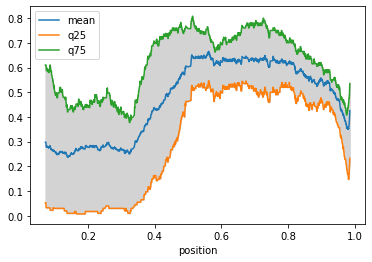

In [16]:
rolling_q25 = mismatches.groupby('position')['mismatch'].quantile(.25).rolling(window=100).mean()
rolling_q75 = mismatches.groupby('position')['mismatch'].quantile(.75).rolling(window=100).mean()
rolling_window = mismatches.groupby('position')['mismatch'].mean().rolling(window=100).mean()

ax = rolling_window.plot(label="mean")
rolling_q25.plot(label='q25', ax=ax)
rolling_q75.plot(label='q75', ax=ax)
ax.fill_between(rolling_window.index, rolling_q25, rolling_q75, color='lightgrey')
plt.legend()
rolling_window.shape

## Clustermap

In [116]:
sigles = sorted(mss.keys())

In [117]:
df_clust = np.zeros((len(sigles), len(sigles)))
print(df_clust.shape)

(3, 3)


In [118]:
for s1, s2 in combinations(sigles, 2):
    print(s1, s2)
    d = mismatches[(mismatches['ms1'] == s1) & (mismatches['ms2'] == s2)]['mismatch'].mean()
    df_clust[sigles.index(s1), sigles.index(s2)] = d
    df_clust[sigles.index(s2), sigles.index(s1)] = d
df_clust

A C
A D
C D


array([[0.        , 0.1913664 , 0.19560996],
       [0.1913664 , 0.        , 0.22679142],
       [0.19560996, 0.22679142, 0.        ]])

In [119]:
df_clust = pd.DataFrame(df_clust, columns=sigles, index=sigles)
df_clust

A         C         D
A  0.000000  0.191366  0.195610
C  0.191366  0.000000  0.226791
D  0.195610  0.226791  0.000000

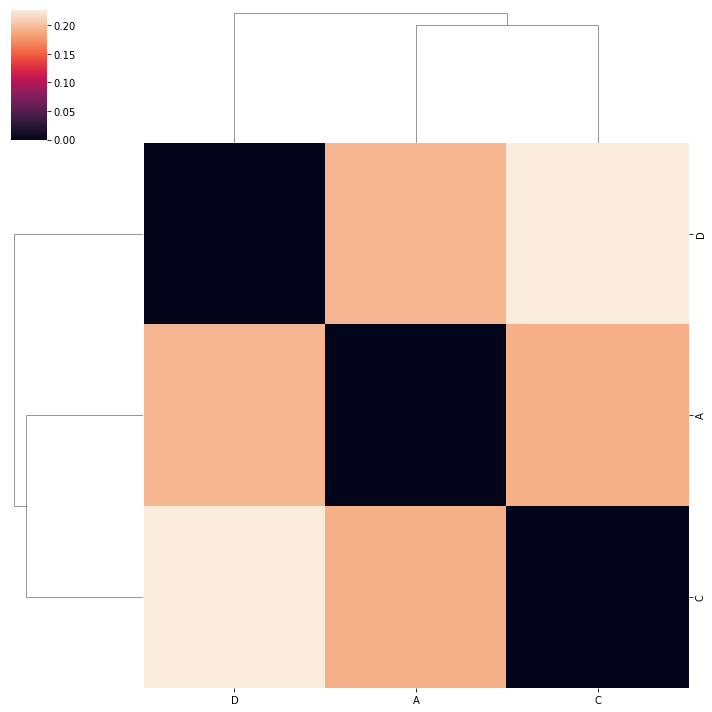

In [121]:
import seaborn as sns
sns.clustermap(df_clust);

## Now create bins for positions in verse line

In [32]:
bins = 25 # how many bins?

edges = np.linspace(mismatches.position.min(), mismatches.position.max(), bins+1).astype(float).round(2)

labels = [f'({edges[i]}, {edges[i+1]}]' for i in range(bins)]
mismatches['position_binned'] = pd.cut(mismatches.position, bins=bins, labels=labels)
mismatches['combo'] = mismatches["ms1"]+'-'+mismatches["ms2"]

mismatches

ms1 ms2  position  mismatch position_binned combo
0      K   L  0.000000         1     (0.0, 0.04]   K-L
1      K   L  0.047619         1    (0.04, 0.08]   K-L
2      K   L  0.095238         1    (0.08, 0.12]   K-L
3      K   L  0.142857         1    (0.12, 0.16]   K-L
4      K   L  0.190476         1    (0.16, 0.19]   K-L
...   ..  ..       ...       ...             ...   ...
1378   K   L  0.800000         0    (0.78, 0.82]   K-L
1379   K   L  0.840000         0    (0.82, 0.85]   K-L
1380   K   L  0.880000         1    (0.85, 0.89]   K-L
1381   K   L  0.920000         1    (0.89, 0.93]   K-L
1382   K   L  0.960000         0    (0.93, 0.97]   K-L

[1383 rows x 6 columns]

In [50]:
df_binned = mismatches.groupby(['position_binned', 'combo'])['mismatch'].sum().reset_index()
df_binned

position_binned combo  mismatch
0      (0.0, 0.04]   A-C       444
1     (0.04, 0.08]   A-C       263
2     (0.08, 0.12]   A-C       308
3     (0.12, 0.16]   A-C       315
4      (0.16, 0.2]   A-C       313
5      (0.2, 0.24]   A-C       322
6     (0.24, 0.27]   A-C       265
7     (0.27, 0.31]   A-C       269
8     (0.31, 0.35]   A-C       277
9     (0.35, 0.39]   A-C       285
10    (0.39, 0.43]   A-C       309
11    (0.43, 0.47]   A-C       293
12    (0.47, 0.51]   A-C       273
13    (0.51, 0.55]   A-C       279
14    (0.55, 0.59]   A-C       272
15    (0.59, 0.63]   A-C       266
16    (0.63, 0.67]   A-C       329
17    (0.67, 0.71]   A-C       256
18    (0.71, 0.75]   A-C       229
19    (0.75, 0.79]   A-C       238
20    (0.79, 0.82]   A-C       220
21    (0.82, 0.86]   A-C       186
22     (0.86, 0.9]   A-C       116
23     (0.9, 0.94]   A-C        77
24    (0.94, 0.98]   A-C       144

In [51]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import seaborn as sns
import pandas as pd # for data analysis
import numpy as np # for numeric calculation
import matplotlib.pyplot as plt # for data visualization
from matplotlib import pyplot as plt

result_binned = df_binned.pivot(index='combo', columns='position_binned', values='mismatch')
fig, ax = plt.subplots(figsize=(16,10)

sns.heatmap(result_binned, fmt="g", cmap='viridis', linewidths=.5) #annot=True
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-078ca063188d>, line 10)